## Set up R and rpy2 v3.4.2 in notebook (for model 7)

**\*\* Runtime needs to be restarted after running 1st code cell (~30s) once**

In [ ]:
pip install --force-reinstall 'rpy2==3.4.2'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 186 kB 8.7 MB/s 
     |████████████████████████████████| 427 kB 49.5 MB/s 
     |████████████████████████████████| 133 kB 43.0 MB/s 
     |████████████████████████████████| 498 kB 54.3 MB/s 
     |████████████████████████████████| 118 kB 54.8 MB/s 
     |████████████████████████████████| 70 kB 8.2 MB/s 
     |████████████████████████████████| 338 kB 54.0 MB/s 
  Created wheel for rpy2: filename=rpy2-3.4.2-cp37-cp37m-linux_x86_64.whl size=281295 sha256=33c4a92d007d5f4ffa3b6260cf3eba188126dc6499563cf9f488de7205bb3864
  Stored in directory: /root/.cache/pip/wheels/64/4a/54/3935d6a74320a93a8a7f5a0534fb05574b0a5a8240cfeb1e77
Successfully built rpy2
  Attempting uninstall: pycparser
    Found existing installation: pycparser 2.21
    Uninstalling pycparser-2.21:
      Successfully uninstalled pycparser-2.21
  Attempting uninstall: MarkupSafe
    Found exi

## Dummy variables & Normalization

Dataset description page: https://archive.ics.uci.edu/ml/datasets/Facebook+Comment+Volume+Dataset

In [ ]:
# Loading the dataset(zipped) with a google drive id
! gdown 1ak_rxZ1XrenunEZK62t9U61XYe8mp-EU

# Unzipping the dataset to a folder named "unzipped_data". The directory can be found by clicking on the Files icon on the leftmost column
# The command automatically checks for existence of unzipped data so re-running it does not lead to multiple unzips
# However, running it for the first time will generate a bunch of checker prints. To remove them for simplicity, simply re-run this cell
!unzip -u "/content/Dataset.zip" -d "/content/unzipped_data"

Downloading...
From: https://drive.google.com/uc?id=1ak_rxZ1XrenunEZK62t9U61XYe8mp-EU
To: /content/Dataset.zip
100% 19.1M/19.1M [00:00<00:00, 49.2MB/s]
Archive:  /content/Dataset.zip


In [ ]:
import pandas as pd
import numpy as np
import sklearn.preprocessing
from sklearn.preprocessing import MinMaxScaler

column_names = {0: "page_likes",
                1: "page_checkins", #page visits
                2: "page_talking_about",
                3: "page_category",
                4: "min_CC1",
                5: "max_CC1",
                6: "ave_CC1",
                7: "med_CC1",
                8: "std_CC1",
                9: "min_CC2",
                10: "max_CC2",
                11: "ave_CC2",
                12: "med_CC2",
                13: "std_CC2",
                14: "min_CC3",
                15: "max_CC3",
                16: "ave_CC3",
                17: "med_CC3",
                18: "std_CC3",
                19: "min_CC4",
                20: "max_CC4",
                21: "ave_CC4",
                22: "med_CC4",
                23: "std_CC4",
                24: "min_CC5",
                25: "max_CC5",
                26: "ave_CC5",
                27: "med_CC5",
                28: "std_CC5",
                29: "CC1",
                30: "CC2",
                31: "CC3",
                32: "CC4",
                33: "CC5",
                34: "base_time",
                35: "post_length",
                36: "post_share_count",
                37: "post_isPromoted",
                38: "h_local",
                39: "published_on_sun",
                40: "published_on_mon",
                41: "published_on_tue",
                42: "published_on_wed",
                43: "published_on_thu",
                44: "published_on_fri",
                45: "published_on_sat",
                46: "base_day_sun",
                47: "base_day_mon",
                48: "base_day_tue",
                49: "base_day_wed",
                50: "base_day_thu",
                51: "base_day_fri",
                52: "base_day_sat",
                53: "num_comments_in_next_h"}


def norm(df):
  df_X = df.drop(columns='num_comments_in_next_h')
  df_y = df[['num_comments_in_next_h']]
  # print(df_y)
  scaler = MinMaxScaler()
  scaler.fit(df_X)
  df_X_norm = scaler.transform(df_X)
  df_X_norm = pd.DataFrame(df_X_norm, columns = df_X.columns)
  df_norm = pd.concat([df_X_norm, df_y], axis=1)
  # print(df_norm[['num_comments_in_next_h']])
  return df_norm

df1 = pd.read_csv("/content/unzipped_data/Dataset/Training/Features_Variant_1.csv", header = None)

# Rename columns 
df1 = df1.rename(columns = column_names)

# Convert catogory to dummy variables
dummy_df1 = pd.get_dummies(df1, columns=['page_category'])

# Split train & test data
df1_train = dummy_df1.sample(frac = 0.8, random_state=3244)
df1_test = dummy_df1.drop(df1_train.index)

df1_test_reindex = df1_test.reset_index(drop=True)
df1_train_reindex = df1_train.reset_index(drop=True)

# Normalize train and test data separately
df1_train_norm = norm(df1_train_reindex)
df1_test_norm = norm(df1_test_reindex)

y_train = pd.DataFrame(df1_train_norm.loc[:,["num_comments_in_next_h"]], dtype=float)
X_train = pd.DataFrame(df1_train_norm.loc[:, df1_train_norm.columns != "num_comments_in_next_h"], dtype=float)

y_test = pd.DataFrame(df1_test_norm.loc[:,["num_comments_in_next_h"]], dtype=float)
X_test = pd.DataFrame(df1_test_norm.loc[:, df1_test_norm.columns != "num_comments_in_next_h"], dtype=float)

## 6 - linear regression with significant features based on p-value

### Set up R in notebook to find significant features based on p-value

references:

https://medium.com/grabngoinfo/how-to-use-r-with-google-colab-notebook-610c3a2f0eab

https://github.com/theislab/anndata2ri/issues/63

In [ ]:
# Highly Correlated (corr > 0.9) features: "ave_CC1", "std_CC1", "max_CC2", "min_CC4", "max_CC4", "CC4"
drop_corr_features = ["min_CC1", "max_CC1", "med_CC1", "ave_CC2", "std_CC2", 
                      "ave_CC3", "std_CC3", "ave_CC4", "med_CC4", "std_CC4", 
                      "max_CC5", "std_CC5", "CC1"]

df1 = pd.DataFrame(df1.drop(drop_corr_features, axis=1))

#print(str(df1))

In [ ]:
%load_ext rpy2.ipython

In [ ]:
# Import rpy2 for dataframe conversion
import rpy2.robjects as ro
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
from rpy2.robjects.conversion import localconverter
from rpy2.robjects import globalenv
pandas2ri.activate()

In [ ]:
# Convert the python dataframe to the R dataframe
with localconverter(ro.default_converter + pandas2ri.converter):
  df1_r = ro.conversion.py2rpy(df1)
# Create a variable name in R's global environment
ro.globalenv['df1_r'] = df1_r

### Perform significance testing to find significant features based on p-value

In [ ]:
%%R
library(dplyr)

df1_cat_r <- df1_r %>% 
  mutate(published_day = case_when(
    published_on_mon == 1 ~ 1,
    published_on_tue == 1 ~ 2,
    published_on_wed == 1 ~ 3,
    published_on_thu == 1 ~ 4,
    published_on_fri == 1 ~ 5,
    published_on_sat == 1 ~ 6,
    published_on_sun == 1 ~ 7,
  ), base_day = case_when(
    base_day_mon == 1 ~ 1, 
    base_day_tue == 1 ~ 2,
    base_day_wed == 1 ~ 3, 
    base_day_thu == 1 ~ 4, 
    base_day_fri == 1 ~ 5, 
    base_day_sat == 1 ~ 6, 
    base_day_sun == 1 ~ 7, 
  )) %>% 
  select(-(published_on_sun:published_on_sat)) %>% 
  select(-(base_day_sun:base_day_sat))

df1_cat_r$post_isPromoted <- as.factor(df1_cat_r$post_isPromoted)
df1_cat_r$page_category <- as.factor(df1_cat_r$page_category)
df1_cat_r$published_day <- as.factor(df1_cat_r$published_day)
df1_cat_r$base_day <- as.factor(df1_cat_r$base_day)

Attaching package: ‘dplyr’



    filter, lag



    intersect, setdiff, setequal, union




In [ ]:
%%R
## Fitting the regression model
df1_cat_r.fit <- lm(num_comments_in_next_h ~ 
                       page_likes + page_checkins + 
                       page_talking_about + page_category + 
                       ave_CC1 + std_CC1 + min_CC2 + 
                       max_CC2 + med_CC2 + min_CC3 + 
                       max_CC3 + med_CC3 + 
                       min_CC4 + max_CC4 + min_CC5 + 
                       ave_CC5 + med_CC5 + CC2 + 
                       CC3 + CC4 + CC5 + 
                       base_time + post_length + 
                       post_share_count + h_local + 
                       published_day + base_day, 
                       data = df1_cat_r)
## excluded column post_isPromoted because all value = 0

In [ ]:
%%R
summary(df1_cat_r.fit)


Call:
lm(formula = num_comments_in_next_h ~ page_likes + page_checkins + 
    page_talking_about + page_category + ave_CC1 + std_CC1 + 
    min_CC2 + max_CC2 + med_CC2 + min_CC3 + max_CC3 + med_CC3 + 
    min_CC4 + max_CC4 + min_CC5 + ave_CC5 + med_CC5 + CC2 + CC3 + 
    CC4 + CC5 + base_time + post_length + post_share_count + 
    h_local + published_day + base_day, data = df1_cat_r)

Residuals:
    Min      1Q  Median      3Q     Max 
-344.74   -5.31   -1.12    2.88 1272.86 

Coefficients: (1 not defined because of singularities)
                     Estimate Std. Error t value Pr(>|t|)    
(Intercept)        -2.612e+00  2.229e+00  -1.172 0.241227    
page_likes          5.485e-08  3.021e-08   1.815 0.069475 .  
page_checkins      -1.668e-05  7.676e-06  -2.173 0.029784 *  
page_talking_about -1.843e-05  2.401e-06  -7.676 1.68e-14 ***
page_category2     -9.162e-01  1.337e+00  -0.685 0.493199    
page_category3      8.728e-01  2.360e+00   0.370 0.711532    
page_category4      8.283e-

In [ ]:
# Top 15 most significant features by p-value (α = 0.01):
#sig_features = ["page_talking_about", "page_category_25", "std_CC1", "min_CC2", 
#                "med_CC2", "med_CC3", "max_CC4", "CC2", "CC3", "CC4", 
#                "base_time", "post_share_count", "h_local", 
#                "page_category_31", "ave_CC5"]

## SelectKBest

references:

https://www.datatechnotes.com/2021/02/seleckbest-feature-selection-example-in-python.html

https://www.simplilearn.com/tutorials/scikit-learn-tutorial/sklearn-linear-regression-with-examples

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from numpy import array

## iteratively find the k best features and find the corresponding r2 score
features = array(X_train.columns)

def generate_best_k_features():
  best_k_r2 = []

  for num_features in range(len(features)):
    num_features += 1
    select = SelectKBest(score_func = f_regression, k = num_features)
    z = select.fit_transform(X_train, y_train) 
    
    print("After selecting best " + str(num_features) + " features:", z.shape) 
    
    filter = select.get_support()
    
    print("Selected best " + str(num_features) + " features:")
    print(features[filter])
    print(z) 

    X_train_k = X_train.loc[:, filter]
    est = LinearRegression()
    est = est.fit(X_train_k, y_train)
    indiv_r2_score = est.score(X_train_k, y_train)
    best_k_r2.append(indiv_r2_score)

  best_r2_score = max(best_k_r2)
  best_r2_index = best_k_r2.index(best_r2_score)
  print("Best k:", best_r2_index + 1)

  return([best_k_r2, best_r2_index])

all_r2_for_bestk = generate_best_k_features()
all_r2 = all_r2_for_bestk[0]
bestr2_index = all_r2_for_bestk[1]   # optimum k value = bestr2_index + 1

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A col

After selecting best 1 features: (32759, 1)
Selected best 1 features:
['CC2']
[[0.      ]
 [0.      ]
 [0.      ]
 ...
 [0.001924]
 [0.001443]
 [0.000481]]
After selecting best 2 features: (32759, 2)
Selected best 2 features:
['CC2' 'CC5']
[[0.         0.39506531]
 [0.         0.39448476]
 [0.         0.39651669]
 ...
 [0.001924   0.39361393]
 [0.001443   0.38809869]
 [0.000481   0.39274311]]
After selecting best 3 features: (32759, 3)
Selected best 3 features:
['ave_CC2' 'CC2' 'CC5']
[[0.00067673 0.         0.39506531]
 [0.00995937 0.         0.39448476]
 [0.00156495 0.         0.39651669]
 ...
 [0.00432127 0.001924   0.39361393]
 [0.040346   0.001443   0.38809869]
 [0.09306682 0.000481   0.39274311]]
After selecting best 4 features: (32759, 4)
Selected best 4 features:
['ave_CC2' 'CC2' 'CC4' 'CC5']
[[0.00067673 0.         0.00320513 0.39506531]
 [0.00995937 0.         0.00320513 0.39448476]
 [0.00156495 0.         0.         0.39651669]
 ...
 [0.00432127 0.001924   0.00732601 0.39361

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A col

After selecting best 5 features: (32759, 5)
Selected best 5 features:
['ave_CC1' 'ave_CC2' 'CC2' 'CC4' 'CC5']
[[0.00072734 0.00067673 0.         0.00320513 0.39506531]
 [0.00707263 0.00995937 0.         0.00320513 0.39448476]
 [0.00142004 0.00156495 0.         0.         0.39651669]
 ...
 [0.00316104 0.00432127 0.001924   0.00732601 0.39361393]
 [0.02514977 0.040346   0.001443   0.01602564 0.38809869]
 [0.05966111 0.09306682 0.000481   0.04578755 0.39274311]]
After selecting best 6 features: (32759, 6)
Selected best 6 features:
['ave_CC1' 'ave_CC2' 'ave_CC4' 'CC2' 'CC4' 'CC5']
[[0.00072734 0.00067673 0.00081209 0.         0.00320513 0.39506531]
 [0.00707263 0.00995937 0.00820085 0.         0.00320513 0.39448476]
 [0.00142004 0.00156495 0.00165268 0.         0.         0.39651669]
 ...
 [0.00316104 0.00432127 0.00359821 0.001924   0.00732601 0.39361393]
 [0.02514977 0.040346   0.03004482 0.001443   0.01602564 0.38809869]
 [0.05966111 0.09306682 0.06881679 0.000481   0.04578755 0.3927431

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A col

After selecting best 9 features: (32759, 9)
Selected best 9 features:
['ave_CC1' 'med_CC1' 'ave_CC2' 'ave_CC4' 'med_CC4' 'CC1' 'CC2' 'CC4' 'CC5']
[[0.00072734 0.00042717 0.00067673 ... 0.         0.00320513 0.39506531]
 [0.00707263 0.00427168 0.00995937 ... 0.         0.00320513 0.39448476]
 [0.00142004 0.00042717 0.00156495 ... 0.         0.         0.39651669]
 ...
 [0.00316104 0.00085434 0.00432127 ... 0.001924   0.00732601 0.39361393]
 [0.02514977 0.0132422  0.040346   ... 0.001443   0.01602564 0.38809869]
 [0.05966111 0.0465613  0.09306682 ... 0.000481   0.04578755 0.39274311]]
After selecting best 10 features: (32759, 10)
Selected best 10 features:
['ave_CC1' 'med_CC1' 'ave_CC2' 'ave_CC3' 'ave_CC4' 'med_CC4' 'CC1' 'CC2'
 'CC4' 'CC5']
[[0.00072734 0.00042717 0.00067673 ... 0.         0.00320513 0.39506531]
 [0.00707263 0.00427168 0.00995937 ... 0.         0.00320513 0.39448476]
 [0.00142004 0.00042717 0.00156495 ... 0.         0.         0.39651669]
 ...
 [0.00316104 0.00085434 0.

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms


After selecting best 12 features: (32759, 12)
Selected best 12 features:
['ave_CC1' 'med_CC1' 'ave_CC2' 'med_CC2' 'ave_CC3' 'ave_CC4' 'med_CC4'
 'std_CC5' 'CC1' 'CC2' 'CC4' 'CC5']
[[0.00072734 0.00042717 0.00067673 ... 0.         0.00320513 0.39506531]
 [0.00707263 0.00427168 0.00995937 ... 0.         0.00320513 0.39448476]
 [0.00142004 0.00042717 0.00156495 ... 0.         0.         0.39651669]
 ...
 [0.00316104 0.00085434 0.00432127 ... 0.001924   0.00732601 0.39361393]
 [0.02514977 0.0132422  0.040346   ... 0.001443   0.01602564 0.38809869]
 [0.05966111 0.0465613  0.09306682 ... 0.000481   0.04578755 0.39274311]]
After selecting best 13 features: (32759, 13)
Selected best 13 features:
['ave_CC1' 'med_CC1' 'std_CC1' 'ave_CC2' 'med_CC2' 'ave_CC3' 'ave_CC4'
 'med_CC4' 'std_CC5' 'CC1' 'CC2' 'CC4' 'CC5']
[[0.00072734 0.00042717 0.002657   ... 0.         0.00320513 0.39506531]
 [0.00707263 0.00427168 0.02632395 ... 0.         0.00320513 0.39448476]
 [0.00142004 0.00042717 0.00702977 ... 0

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


After selecting best 14 features: (32759, 14)
Selected best 14 features:
['ave_CC1' 'med_CC1' 'std_CC1' 'ave_CC2' 'med_CC2' 'ave_CC3' 'std_CC3'
 'ave_CC4' 'med_CC4' 'std_CC5' 'CC1' 'CC2' 'CC4' 'CC5']
[[0.00072734 0.00042717 0.002657   ... 0.         0.00320513 0.39506531]
 [0.00707263 0.00427168 0.02632395 ... 0.         0.00320513 0.39448476]
 [0.00142004 0.00042717 0.00702977 ... 0.         0.         0.39651669]
 ...
 [0.00316104 0.00085434 0.02501039 ... 0.001924   0.00732601 0.39361393]
 [0.02514977 0.0132422  0.13418336 ... 0.001443   0.01602564 0.38809869]
 [0.05966111 0.0465613  0.15591302 ... 0.000481   0.04578755 0.39274311]]
After selecting best 15 features: (32759, 15)
Selected best 15 features:
['ave_CC1' 'med_CC1' 'std_CC1' 'ave_CC2' 'med_CC2' 'std_CC2' 'ave_CC3'
 'std_CC3' 'ave_CC4' 'med_CC4' 'std_CC5' 'CC1' 'CC2' 'CC4' 'CC5']
[[0.00072734 0.00042717 0.002657   ... 0.         0.00320513 0.39506531]
 [0.00707263 0.00427168 0.02632395 ... 0.         0.00320513 0.39448476]


/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


After selecting best 16 features: (32759, 16)
Selected best 16 features:
['ave_CC1' 'med_CC1' 'std_CC1' 'ave_CC2' 'med_CC2' 'std_CC2' 'ave_CC3'
 'std_CC3' 'ave_CC4' 'med_CC4' 'std_CC4' 'std_CC5' 'CC1' 'CC2' 'CC4' 'CC5']
[[0.00072734 0.00042717 0.002657   ... 0.         0.00320513 0.39506531]
 [0.00707263 0.00427168 0.02632395 ... 0.         0.00320513 0.39448476]
 [0.00142004 0.00042717 0.00702977 ... 0.         0.         0.39651669]
 ...
 [0.00316104 0.00085434 0.02501039 ... 0.001924   0.00732601 0.39361393]
 [0.02514977 0.0132422  0.13418336 ... 0.001443   0.01602564 0.38809869]
 [0.05966111 0.0465613  0.15591302 ... 0.000481   0.04578755 0.39274311]]
After selecting best 17 features: (32759, 17)
Selected best 17 features:
['ave_CC1' 'med_CC1' 'std_CC1' 'ave_CC2' 'med_CC2' 'std_CC2' 'ave_CC3'
 'med_CC3' 'std_CC3' 'ave_CC4' 'med_CC4' 'std_CC4' 'std_CC5' 'CC1' 'CC2'
 'CC4' 'CC5']
[[0.00072734 0.00042717 0.002657   ... 0.         0.00320513 0.39506531]
 [0.00707263 0.00427168 0.026323

/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms


After selecting best 18 features: (32759, 18)
Selected best 18 features:
['ave_CC1' 'med_CC1' 'std_CC1' 'ave_CC2' 'med_CC2' 'std_CC2' 'max_CC3'
 'ave_CC3' 'med_CC3' 'std_CC3' 'ave_CC4' 'med_CC4' 'std_CC4' 'std_CC5'
 'CC1' 'CC2' 'CC4' 'CC5']
[[0.00072734 0.00042717 0.002657   ... 0.         0.00320513 0.39506531]
 [0.00707263 0.00427168 0.02632395 ... 0.         0.00320513 0.39448476]
 [0.00142004 0.00042717 0.00702977 ... 0.         0.         0.39651669]
 ...
 [0.00316104 0.00085434 0.02501039 ... 0.001924   0.00732601 0.39361393]
 [0.02514977 0.0132422  0.13418336 ... 0.001443   0.01602564 0.38809869]
 [0.05966111 0.0465613  0.15591302 ... 0.000481   0.04578755 0.39274311]]
After selecting best 19 features: (32759, 19)
Selected best 19 features:
['max_CC1' 'ave_CC1' 'med_CC1' 'std_CC1' 'ave_CC2' 'med_CC2' 'std_CC2'
 'max_CC3' 'ave_CC3' 'med_CC3' 'std_CC3' 'ave_CC4' 'med_CC4' 'std_CC4'
 'std_CC5' 'CC1' 'CC2' 'CC4' 'CC5']
[[0.00299018 0.00072734 0.00042717 ... 0.         0.00320513 0.3

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms


After selecting best 20 features: (32759, 20)
Selected best 20 features:
['max_CC1' 'ave_CC1' 'med_CC1' 'std_CC1' 'ave_CC2' 'med_CC2' 'std_CC2'
 'max_CC3' 'ave_CC3' 'med_CC3' 'std_CC3' 'max_CC4' 'ave_CC4' 'med_CC4'
 'std_CC4' 'std_CC5' 'CC1' 'CC2' 'CC4' 'CC5']
[[0.00299018 0.00072734 0.00042717 ... 0.         0.00320513 0.39506531]
 [0.05553182 0.00707263 0.00427168 ... 0.         0.00320513 0.39448476]
 [0.00854336 0.00142004 0.00042717 ... 0.         0.         0.39651669]
 ...
 [0.0837249  0.00316104 0.00085434 ... 0.001924   0.00732601 0.39361393]
 [0.35882102 0.02514977 0.0132422  ... 0.001443   0.01602564 0.38809869]
 [0.2699701  0.05966111 0.0465613  ... 0.000481   0.04578755 0.39274311]]


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms


After selecting best 21 features: (32759, 21)
Selected best 21 features:
['max_CC1' 'ave_CC1' 'med_CC1' 'std_CC1' 'ave_CC2' 'med_CC2' 'std_CC2'
 'max_CC3' 'ave_CC3' 'med_CC3' 'std_CC3' 'max_CC4' 'ave_CC4' 'med_CC4'
 'std_CC4' 'std_CC5' 'CC1' 'CC2' 'CC4' 'CC5' 'base_time']
[[2.99017514e-03 7.27339899e-04 4.27167877e-04 ... 3.20512821e-03
  3.95065312e-01 6.80555556e-01]
 [5.55318240e-02 7.07262603e-03 4.27167877e-03 ... 3.20512821e-03
  3.94484761e-01 5.55555556e-01]
 [8.54335754e-03 1.42004456e-03 4.27167877e-04 ... 0.00000000e+00
  3.96516691e-01 1.38888889e-01]
 ...
 [8.37249039e-02 3.16104229e-03 8.54335754e-04 ... 7.32600733e-03
  3.93613933e-01 6.52777778e-01]
 [3.58821017e-01 2.51497744e-02 1.32422042e-02 ... 1.60256410e-02
  3.88098694e-01 5.27777778e-01]
 [2.69970098e-01 5.96611135e-02 4.65612986e-02 ... 4.57875458e-02
  3.92743106e-01 9.02777778e-01]]
After selecting best 22 features: (32759, 22)
Selected best 22 features:
['max_CC1' 'ave_CC1' 'med_CC1' 'std_CC1' 'ave_CC2' 'me

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms


After selecting best 23 features: (32759, 23)
Selected best 23 features:
['max_CC1' 'ave_CC1' 'med_CC1' 'std_CC1' 'max_CC2' 'ave_CC2' 'med_CC2'
 'std_CC2' 'max_CC3' 'ave_CC3' 'med_CC3' 'std_CC3' 'max_CC4' 'ave_CC4'
 'med_CC4' 'std_CC4' 'min_CC5' 'std_CC5' 'CC1' 'CC2' 'CC4' 'CC5'
 'base_time']
[[2.99017514e-03 7.27339899e-04 4.27167877e-04 ... 3.20512821e-03
  3.95065312e-01 6.80555556e-01]
 [5.55318240e-02 7.07262603e-03 4.27167877e-03 ... 3.20512821e-03
  3.94484761e-01 5.55555556e-01]
 [8.54335754e-03 1.42004456e-03 4.27167877e-04 ... 0.00000000e+00
  3.96516691e-01 1.38888889e-01]
 ...
 [8.37249039e-02 3.16104229e-03 8.54335754e-04 ... 7.32600733e-03
  3.93613933e-01 6.52777778e-01]
 [3.58821017e-01 2.51497744e-02 1.32422042e-02 ... 1.60256410e-02
  3.88098694e-01 5.27777778e-01]
 [2.69970098e-01 5.96611135e-02 4.65612986e-02 ... 4.57875458e-02
  3.92743106e-01 9.02777778e-01]]
After selecting best 24 features: (32759, 24)
Selected best 24 features:
['max_CC1' 'ave_CC1' 'med_CC1' 's

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms


After selecting best 25 features: (32759, 25)
Selected best 25 features:
['page_talking_about' 'max_CC1' 'ave_CC1' 'med_CC1' 'std_CC1' 'max_CC2'
 'ave_CC2' 'med_CC2' 'std_CC2' 'max_CC3' 'ave_CC3' 'med_CC3' 'std_CC3'
 'max_CC4' 'ave_CC4' 'med_CC4' 'std_CC4' 'min_CC5' 'max_CC5' 'std_CC5'
 'CC1' 'CC2' 'CC4' 'CC5' 'base_time']
[[3.44830870e-06 2.99017514e-03 7.27339899e-04 ... 3.20512821e-03
  3.95065312e-01 6.80555556e-01]
 [4.55340954e-04 5.55318240e-02 7.07262603e-03 ... 3.20512821e-03
  3.94484761e-01 5.55555556e-01]
 [7.06082258e-06 8.54335754e-03 1.42004456e-03 ... 0.00000000e+00
  3.96516691e-01 1.38888889e-01]
 ...
 [1.72908051e-04 8.37249039e-02 3.16104229e-03 ... 7.32600733e-03
  3.93613933e-01 6.52777778e-01]
 [1.18569274e-02 3.58821017e-01 2.51497744e-02 ... 1.60256410e-02
  3.88098694e-01 5.27777778e-01]
 [3.98775555e-02 2.69970098e-01 5.96611135e-02 ... 4.57875458e-02
  3.92743106e-01 9.02777778e-01]]


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms


After selecting best 26 features: (32759, 26)
Selected best 26 features:
['page_talking_about' 'max_CC1' 'ave_CC1' 'med_CC1' 'std_CC1' 'max_CC2'
 'ave_CC2' 'med_CC2' 'std_CC2' 'max_CC3' 'ave_CC3' 'med_CC3' 'std_CC3'
 'min_CC4' 'max_CC4' 'ave_CC4' 'med_CC4' 'std_CC4' 'min_CC5' 'max_CC5'
 'std_CC5' 'CC1' 'CC2' 'CC4' 'CC5' 'base_time']
[[3.44830870e-06 2.99017514e-03 7.27339899e-04 ... 3.20512821e-03
  3.95065312e-01 6.80555556e-01]
 [4.55340954e-04 5.55318240e-02 7.07262603e-03 ... 3.20512821e-03
  3.94484761e-01 5.55555556e-01]
 [7.06082258e-06 8.54335754e-03 1.42004456e-03 ... 0.00000000e+00
  3.96516691e-01 1.38888889e-01]
 ...
 [1.72908051e-04 8.37249039e-02 3.16104229e-03 ... 7.32600733e-03
  3.93613933e-01 6.52777778e-01]
 [1.18569274e-02 3.58821017e-01 2.51497744e-02 ... 1.60256410e-02
  3.88098694e-01 5.27777778e-01]
 [3.98775555e-02 2.69970098e-01 5.96611135e-02 ... 4.57875458e-02
  3.92743106e-01 9.02777778e-01]]


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms


After selecting best 27 features: (32759, 27)
Selected best 27 features:
['page_talking_about' 'max_CC1' 'ave_CC1' 'med_CC1' 'std_CC1' 'min_CC2'
 'max_CC2' 'ave_CC2' 'med_CC2' 'std_CC2' 'max_CC3' 'ave_CC3' 'med_CC3'
 'std_CC3' 'min_CC4' 'max_CC4' 'ave_CC4' 'med_CC4' 'std_CC4' 'min_CC5'
 'max_CC5' 'std_CC5' 'CC1' 'CC2' 'CC4' 'CC5' 'base_time']
[[3.44830870e-06 2.99017514e-03 7.27339899e-04 ... 3.20512821e-03
  3.95065312e-01 6.80555556e-01]
 [4.55340954e-04 5.55318240e-02 7.07262603e-03 ... 3.20512821e-03
  3.94484761e-01 5.55555556e-01]
 [7.06082258e-06 8.54335754e-03 1.42004456e-03 ... 0.00000000e+00
  3.96516691e-01 1.38888889e-01]
 ...
 [1.72908051e-04 8.37249039e-02 3.16104229e-03 ... 7.32600733e-03
  3.93613933e-01 6.52777778e-01]
 [1.18569274e-02 3.58821017e-01 2.51497744e-02 ... 1.60256410e-02
  3.88098694e-01 5.27777778e-01]
 [3.98775555e-02 2.69970098e-01 5.96611135e-02 ... 4.57875458e-02
  3.92743106e-01 9.02777778e-01]]


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms


After selecting best 28 features: (32759, 28)
Selected best 28 features:
['page_talking_about' 'max_CC1' 'ave_CC1' 'med_CC1' 'std_CC1' 'min_CC2'
 'max_CC2' 'ave_CC2' 'med_CC2' 'std_CC2' 'max_CC3' 'ave_CC3' 'med_CC3'
 'std_CC3' 'min_CC4' 'max_CC4' 'ave_CC4' 'med_CC4' 'std_CC4' 'min_CC5'
 'max_CC5' 'std_CC5' 'CC1' 'CC2' 'CC4' 'CC5' 'base_time'
 'post_share_count']
[[3.44830870e-06 2.99017514e-03 7.27339899e-04 ... 3.95065312e-01
  6.80555556e-01 2.07097937e-05]
 [4.55340954e-04 5.55318240e-02 7.07262603e-03 ... 3.94484761e-01
  5.55555556e-01 0.00000000e+00]
 [7.06082258e-06 8.54335754e-03 1.42004456e-03 ... 3.96516691e-01
  1.38888889e-01 0.00000000e+00]
 ...
 [1.72908051e-04 8.37249039e-02 3.16104229e-03 ... 3.93613933e-01
  6.52777778e-01 2.69227318e-04]
 [1.18569274e-02 3.58821017e-01 2.51497744e-02 ... 3.88098694e-01
  5.27777778e-01 4.00389344e-04]
 [3.98775555e-02 2.69970098e-01 5.96611135e-02 ... 3.92743106e-01
  9.02777778e-01 4.06602282e-03]]


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms


After selecting best 29 features: (32759, 29)
Selected best 29 features:
['page_talking_about' 'max_CC1' 'ave_CC1' 'med_CC1' 'std_CC1' 'min_CC2'
 'max_CC2' 'ave_CC2' 'med_CC2' 'std_CC2' 'max_CC3' 'ave_CC3' 'med_CC3'
 'std_CC3' 'min_CC4' 'max_CC4' 'ave_CC4' 'med_CC4' 'std_CC4' 'min_CC5'
 'max_CC5' 'ave_CC5' 'std_CC5' 'CC1' 'CC2' 'CC4' 'CC5' 'base_time'
 'post_share_count']
[[3.44830870e-06 2.99017514e-03 7.27339899e-04 ... 3.95065312e-01
  6.80555556e-01 2.07097937e-05]
 [4.55340954e-04 5.55318240e-02 7.07262603e-03 ... 3.94484761e-01
  5.55555556e-01 0.00000000e+00]
 [7.06082258e-06 8.54335754e-03 1.42004456e-03 ... 3.96516691e-01
  1.38888889e-01 0.00000000e+00]
 ...
 [1.72908051e-04 8.37249039e-02 3.16104229e-03 ... 3.93613933e-01
  6.52777778e-01 2.69227318e-04]
 [1.18569274e-02 3.58821017e-01 2.51497744e-02 ... 3.88098694e-01
  5.27777778e-01 4.00389344e-04]
 [3.98775555e-02 2.69970098e-01 5.96611135e-02 ... 3.92743106e-01
  9.02777778e-01 4.06602282e-03]]


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms


After selecting best 30 features: (32759, 30)
Selected best 30 features:
['page_talking_about' 'min_CC1' 'max_CC1' 'ave_CC1' 'med_CC1' 'std_CC1'
 'min_CC2' 'max_CC2' 'ave_CC2' 'med_CC2' 'std_CC2' 'max_CC3' 'ave_CC3'
 'med_CC3' 'std_CC3' 'min_CC4' 'max_CC4' 'ave_CC4' 'med_CC4' 'std_CC4'
 'min_CC5' 'max_CC5' 'ave_CC5' 'std_CC5' 'CC1' 'CC2' 'CC4' 'CC5'
 'base_time' 'post_share_count']
[[3.44830870e-06 0.00000000e+00 2.99017514e-03 ... 3.95065312e-01
  6.80555556e-01 2.07097937e-05]
 [4.55340954e-04 0.00000000e+00 5.55318240e-02 ... 3.94484761e-01
  5.55555556e-01 0.00000000e+00]
 [7.06082258e-06 0.00000000e+00 8.54335754e-03 ... 3.96516691e-01
  1.38888889e-01 0.00000000e+00]
 ...
 [1.72908051e-04 0.00000000e+00 8.37249039e-02 ... 3.93613933e-01
  6.52777778e-01 2.69227318e-04]
 [1.18569274e-02 0.00000000e+00 3.58821017e-01 ... 3.88098694e-01
  5.27777778e-01 4.00389344e-04]
 [3.98775555e-02 4.27167877e-04 2.69970098e-01 ... 3.92743106e-01
  9.02777778e-01 4.06602282e-03]]


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms


After selecting best 31 features: (32759, 31)
Selected best 31 features:
['page_talking_about' 'min_CC1' 'max_CC1' 'ave_CC1' 'med_CC1' 'std_CC1'
 'min_CC2' 'max_CC2' 'ave_CC2' 'med_CC2' 'std_CC2' 'max_CC3' 'ave_CC3'
 'med_CC3' 'std_CC3' 'min_CC4' 'max_CC4' 'ave_CC4' 'med_CC4' 'std_CC4'
 'min_CC5' 'max_CC5' 'ave_CC5' 'med_CC5' 'std_CC5' 'CC1' 'CC2' 'CC4' 'CC5'
 'base_time' 'post_share_count']
[[3.44830870e-06 0.00000000e+00 2.99017514e-03 ... 3.95065312e-01
  6.80555556e-01 2.07097937e-05]
 [4.55340954e-04 0.00000000e+00 5.55318240e-02 ... 3.94484761e-01
  5.55555556e-01 0.00000000e+00]
 [7.06082258e-06 0.00000000e+00 8.54335754e-03 ... 3.96516691e-01
  1.38888889e-01 0.00000000e+00]
 ...
 [1.72908051e-04 0.00000000e+00 8.37249039e-02 ... 3.93613933e-01
  6.52777778e-01 2.69227318e-04]
 [1.18569274e-02 0.00000000e+00 3.58821017e-01 ... 3.88098694e-01
  5.27777778e-01 4.00389344e-04]
 [3.98775555e-02 4.27167877e-04 2.69970098e-01 ... 3.92743106e-01
  9.02777778e-01 4.06602282e-03]]


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms


After selecting best 32 features: (32759, 32)
Selected best 32 features:
['page_talking_about' 'min_CC1' 'max_CC1' 'ave_CC1' 'med_CC1' 'std_CC1'
 'min_CC2' 'max_CC2' 'ave_CC2' 'med_CC2' 'std_CC2' 'max_CC3' 'ave_CC3'
 'med_CC3' 'std_CC3' 'min_CC4' 'max_CC4' 'ave_CC4' 'med_CC4' 'std_CC4'
 'min_CC5' 'max_CC5' 'ave_CC5' 'med_CC5' 'std_CC5' 'CC1' 'CC2' 'CC3' 'CC4'
 'CC5' 'base_time' 'post_share_count']
[[3.44830870e-06 0.00000000e+00 2.99017514e-03 ... 3.95065312e-01
  6.80555556e-01 2.07097937e-05]
 [4.55340954e-04 0.00000000e+00 5.55318240e-02 ... 3.94484761e-01
  5.55555556e-01 0.00000000e+00]
 [7.06082258e-06 0.00000000e+00 8.54335754e-03 ... 3.96516691e-01
  1.38888889e-01 0.00000000e+00]
 ...
 [1.72908051e-04 0.00000000e+00 8.37249039e-02 ... 3.93613933e-01
  6.52777778e-01 2.69227318e-04]
 [1.18569274e-02 0.00000000e+00 3.58821017e-01 ... 3.88098694e-01
  5.27777778e-01 4.00389344e-04]
 [3.98775555e-02 4.27167877e-04 2.69970098e-01 ... 3.92743106e-01
  9.02777778e-01 4.06602282e-03]]

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms


After selecting best 33 features: (32759, 33)
Selected best 33 features:
['page_talking_about' 'min_CC1' 'max_CC1' 'ave_CC1' 'med_CC1' 'std_CC1'
 'min_CC2' 'max_CC2' 'ave_CC2' 'med_CC2' 'std_CC2' 'max_CC3' 'ave_CC3'
 'med_CC3' 'std_CC3' 'min_CC4' 'max_CC4' 'ave_CC4' 'med_CC4' 'std_CC4'
 'min_CC5' 'max_CC5' 'ave_CC5' 'med_CC5' 'std_CC5' 'CC1' 'CC2' 'CC3' 'CC4'
 'CC5' 'base_time' 'post_share_count' 'page_category_9']
[[3.44830870e-06 0.00000000e+00 2.99017514e-03 ... 6.80555556e-01
  2.07097937e-05 0.00000000e+00]
 [4.55340954e-04 0.00000000e+00 5.55318240e-02 ... 5.55555556e-01
  0.00000000e+00 0.00000000e+00]
 [7.06082258e-06 0.00000000e+00 8.54335754e-03 ... 1.38888889e-01
  0.00000000e+00 0.00000000e+00]
 ...
 [1.72908051e-04 0.00000000e+00 8.37249039e-02 ... 6.52777778e-01
  2.69227318e-04 0.00000000e+00]
 [1.18569274e-02 0.00000000e+00 3.58821017e-01 ... 5.27777778e-01
  4.00389344e-04 1.00000000e+00]
 [3.98775555e-02 4.27167877e-04 2.69970098e-01 ... 9.02777778e-01
  4.06602282e-0

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


After selecting best 34 features: (32759, 34)
Selected best 34 features:
['page_likes' 'page_talking_about' 'min_CC1' 'max_CC1' 'ave_CC1' 'med_CC1'
 'std_CC1' 'min_CC2' 'max_CC2' 'ave_CC2' 'med_CC2' 'std_CC2' 'max_CC3'
 'ave_CC3' 'med_CC3' 'std_CC3' 'min_CC4' 'max_CC4' 'ave_CC4' 'med_CC4'
 'std_CC4' 'min_CC5' 'max_CC5' 'ave_CC5' 'med_CC5' 'std_CC5' 'CC1' 'CC2'
 'CC3' 'CC4' 'CC5' 'base_time' 'post_share_count' 'page_category_9']
[[1.62021549e-06 3.44830870e-06 0.00000000e+00 ... 6.80555556e-01
  2.07097937e-05 0.00000000e+00]
 [4.91793926e-05 4.55340954e-04 0.00000000e+00 ... 5.55555556e-01
  0.00000000e+00 0.00000000e+00]
 [3.66940818e-05 7.06082258e-06 0.00000000e+00 ... 1.38888889e-01
  0.00000000e+00 0.00000000e+00]
 ...
 [2.03290840e-04 1.72908051e-04 0.00000000e+00 ... 6.52777778e-01
  2.69227318e-04 0.00000000e+00]
 [1.40455228e-03 1.18569274e-02 0.00000000e+00 ... 5.27777778e-01
  4.00389344e-04 1.00000000e+00]
 [3.99836532e-03 3.98775555e-02 4.27167877e-04 ... 9.02777778e-01
  

/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms


After selecting best 36 features: (32759, 36)
Selected best 36 features:
['page_likes' 'page_talking_about' 'min_CC1' 'max_CC1' 'ave_CC1' 'med_CC1'
 'std_CC1' 'min_CC2' 'max_CC2' 'ave_CC2' 'med_CC2' 'std_CC2' 'max_CC3'
 'ave_CC3' 'med_CC3' 'std_CC3' 'min_CC4' 'max_CC4' 'ave_CC4' 'med_CC4'
 'std_CC4' 'min_CC5' 'max_CC5' 'ave_CC5' 'med_CC5' 'std_CC5' 'CC1' 'CC2'
 'CC3' 'CC4' 'CC5' 'base_time' 'post_share_count' 'page_category_8'
 'page_category_9' 'page_category_25']
[[1.62021549e-06 3.44830870e-06 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [4.91793926e-05 4.55340954e-04 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [3.66940818e-05 7.06082258e-06 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [2.03290840e-04 1.72908051e-04 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [1.40455228e-03 1.18569274e-02 0.00000000e+00 ... 0.00000000e+00
  1.00000000e+00 0.00000000e+00]
 [3.99836532e-03 3.98775555e-0

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms


After selecting best 38 features: (32759, 38)
Selected best 38 features:
['page_likes' 'page_talking_about' 'min_CC1' 'max_CC1' 'ave_CC1' 'med_CC1'
 'std_CC1' 'min_CC2' 'max_CC2' 'ave_CC2' 'med_CC2' 'std_CC2' 'max_CC3'
 'ave_CC3' 'med_CC3' 'std_CC3' 'min_CC4' 'max_CC4' 'ave_CC4' 'med_CC4'
 'std_CC4' 'min_CC5' 'max_CC5' 'ave_CC5' 'med_CC5' 'std_CC5' 'CC1' 'CC2'
 'CC3' 'CC4' 'CC5' 'base_time' 'post_share_count' 'page_category_8'
 'page_category_9' 'page_category_14' 'page_category_25'
 'page_category_32']
[[1.62021549e-06 3.44830870e-06 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [4.91793926e-05 4.55340954e-04 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [3.66940818e-05 7.06082258e-06 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [2.03290840e-04 1.72908051e-04 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 1.00000000e+00]
 [1.40455228e-03 1.18569274e-02 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms


After selecting best 40 features: (32759, 40)
Selected best 40 features:
['page_likes' 'page_talking_about' 'min_CC1' 'max_CC1' 'ave_CC1' 'med_CC1'
 'std_CC1' 'min_CC2' 'max_CC2' 'ave_CC2' 'med_CC2' 'std_CC2' 'max_CC3'
 'ave_CC3' 'med_CC3' 'std_CC3' 'min_CC4' 'max_CC4' 'ave_CC4' 'med_CC4'
 'std_CC4' 'min_CC5' 'max_CC5' 'ave_CC5' 'med_CC5' 'std_CC5' 'CC1' 'CC2'
 'CC3' 'CC4' 'CC5' 'base_time' 'post_share_count' 'page_category_4'
 'page_category_8' 'page_category_9' 'page_category_14' 'page_category_25'
 'page_category_32' 'page_category_42']
[[1.62021549e-06 3.44830870e-06 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [4.91793926e-05 4.55340954e-04 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [3.66940818e-05 7.06082258e-06 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [2.03290840e-04 1.72908051e-04 0.00000000e+00 ... 0.00000000e+00
  1.00000000e+00 0.00000000e+00]
 [1.40455228e-03 1.18569274e-02 0.00000000e+00 ... 0.

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms


After selecting best 42 features: (32759, 42)
Selected best 42 features:
['page_likes' 'page_talking_about' 'min_CC1' 'max_CC1' 'ave_CC1' 'med_CC1'
 'std_CC1' 'min_CC2' 'max_CC2' 'ave_CC2' 'med_CC2' 'std_CC2' 'max_CC3'
 'ave_CC3' 'med_CC3' 'std_CC3' 'min_CC4' 'max_CC4' 'ave_CC4' 'med_CC4'
 'std_CC4' 'min_CC5' 'max_CC5' 'ave_CC5' 'med_CC5' 'std_CC5' 'CC1' 'CC2'
 'CC3' 'CC4' 'CC5' 'base_time' 'post_share_count' 'page_category_4'
 'page_category_5' 'page_category_8' 'page_category_9' 'page_category_14'
 'page_category_16' 'page_category_25' 'page_category_32'
 'page_category_42']
[[1.62021549e-06 3.44830870e-06 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [4.91793926e-05 4.55340954e-04 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [3.66940818e-05 7.06082258e-06 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [2.03290840e-04 1.72908051e-04 0.00000000e+00 ... 0.00000000e+00
  1.00000000e+00 0.00000000e+00]
 [1.40455228e-0

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms


After selecting best 44 features: (32759, 44)
Selected best 44 features:
['page_likes' 'page_talking_about' 'min_CC1' 'max_CC1' 'ave_CC1' 'med_CC1'
 'std_CC1' 'min_CC2' 'max_CC2' 'ave_CC2' 'med_CC2' 'std_CC2' 'max_CC3'
 'ave_CC3' 'med_CC3' 'std_CC3' 'min_CC4' 'max_CC4' 'ave_CC4' 'med_CC4'
 'std_CC4' 'min_CC5' 'max_CC5' 'ave_CC5' 'med_CC5' 'std_CC5' 'CC1' 'CC2'
 'CC3' 'CC4' 'CC5' 'base_time' 'post_share_count' 'page_category_1'
 'page_category_4' 'page_category_5' 'page_category_8' 'page_category_9'
 'page_category_14' 'page_category_16' 'page_category_18'
 'page_category_25' 'page_category_32' 'page_category_42']
[[1.62021549e-06 3.44830870e-06 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [4.91793926e-05 4.55340954e-04 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [3.66940818e-05 7.06082258e-06 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [2.03290840e-04 1.72908051e-04 0.00000000e+00 ... 0.00000000e+00
  1.0000000

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms


After selecting best 46 features: (32759, 46)
Selected best 46 features:
['page_likes' 'page_checkins' 'page_talking_about' 'min_CC1' 'max_CC1'
 'ave_CC1' 'med_CC1' 'std_CC1' 'min_CC2' 'max_CC2' 'ave_CC2' 'med_CC2'
 'std_CC2' 'max_CC3' 'ave_CC3' 'med_CC3' 'std_CC3' 'min_CC4' 'max_CC4'
 'ave_CC4' 'med_CC4' 'std_CC4' 'min_CC5' 'max_CC5' 'ave_CC5' 'med_CC5'
 'std_CC5' 'CC1' 'CC2' 'CC3' 'CC4' 'CC5' 'base_time' 'post_share_count'
 'page_category_1' 'page_category_4' 'page_category_5' 'page_category_8'
 'page_category_9' 'page_category_14' 'page_category_16'
 'page_category_17' 'page_category_18' 'page_category_25'
 'page_category_32' 'page_category_42']
[[1.62021549e-06 0.00000000e+00 3.44830870e-06 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [4.91793926e-05 9.55089338e-04 4.55340954e-04 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [3.66940818e-05 3.75596931e-05 7.06082258e-06 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [2.03290840e-04 2.22138756e-03 1.7290805

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms


After selecting best 48 features: (32759, 48)
Selected best 48 features:
['page_likes' 'page_checkins' 'page_talking_about' 'min_CC1' 'max_CC1'
 'ave_CC1' 'med_CC1' 'std_CC1' 'min_CC2' 'max_CC2' 'ave_CC2' 'med_CC2'
 'std_CC2' 'max_CC3' 'ave_CC3' 'med_CC3' 'std_CC3' 'min_CC4' 'max_CC4'
 'ave_CC4' 'med_CC4' 'std_CC4' 'min_CC5' 'max_CC5' 'ave_CC5' 'med_CC5'
 'std_CC5' 'CC1' 'CC2' 'CC3' 'CC4' 'CC5' 'base_time' 'post_share_count'
 'page_category_1' 'page_category_4' 'page_category_5' 'page_category_8'
 'page_category_9' 'page_category_14' 'page_category_16'
 'page_category_17' 'page_category_18' 'page_category_25'
 'page_category_27' 'page_category_32' 'page_category_42'
 'page_category_61']
[[1.62021549e-06 0.00000000e+00 3.44830870e-06 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [4.91793926e-05 9.55089338e-04 4.55340954e-04 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [3.66940818e-05 3.75596931e-05 7.06082258e-06 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms


After selecting best 50 features: (32759, 50)
Selected best 50 features:
['page_likes' 'page_checkins' 'page_talking_about' 'min_CC1' 'max_CC1'
 'ave_CC1' 'med_CC1' 'std_CC1' 'min_CC2' 'max_CC2' 'ave_CC2' 'med_CC2'
 'std_CC2' 'max_CC3' 'ave_CC3' 'med_CC3' 'std_CC3' 'min_CC4' 'max_CC4'
 'ave_CC4' 'med_CC4' 'std_CC4' 'min_CC5' 'max_CC5' 'ave_CC5' 'med_CC5'
 'std_CC5' 'CC1' 'CC2' 'CC3' 'CC4' 'CC5' 'base_time' 'post_share_count'
 'page_category_1' 'page_category_4' 'page_category_5' 'page_category_8'
 'page_category_9' 'page_category_14' 'page_category_16'
 'page_category_17' 'page_category_18' 'page_category_25'
 'page_category_27' 'page_category_28' 'page_category_32'
 'page_category_42' 'page_category_46' 'page_category_61']
[[1.62021549e-06 0.00000000e+00 3.44830870e-06 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [4.91793926e-05 9.55089338e-04 4.55340954e-04 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [3.66940818e-05 3.75596931e-05 7.06082258e-06 ... 0.00000000e+00
  

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms


After selecting best 52 features: (32759, 52)
Selected best 52 features:
['page_likes' 'page_checkins' 'page_talking_about' 'min_CC1' 'max_CC1'
 'ave_CC1' 'med_CC1' 'std_CC1' 'min_CC2' 'max_CC2' 'ave_CC2' 'med_CC2'
 'std_CC2' 'max_CC3' 'ave_CC3' 'med_CC3' 'std_CC3' 'min_CC4' 'max_CC4'
 'ave_CC4' 'med_CC4' 'std_CC4' 'min_CC5' 'max_CC5' 'ave_CC5' 'med_CC5'
 'std_CC5' 'CC1' 'CC2' 'CC3' 'CC4' 'CC5' 'base_time' 'post_share_count'
 'page_category_1' 'page_category_4' 'page_category_5' 'page_category_8'
 'page_category_9' 'page_category_14' 'page_category_16'
 'page_category_17' 'page_category_18' 'page_category_25'
 'page_category_26' 'page_category_27' 'page_category_28'
 'page_category_32' 'page_category_42' 'page_category_46'
 'page_category_55' 'page_category_61']
[[1.62021549e-06 0.00000000e+00 3.44830870e-06 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [4.91793926e-05 9.55089338e-04 4.55340954e-04 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [3.66940818e-05 3.75596931e-

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms


After selecting best 54 features: (32759, 54)
Selected best 54 features:
['page_likes' 'page_checkins' 'page_talking_about' 'min_CC1' 'max_CC1'
 'ave_CC1' 'med_CC1' 'std_CC1' 'min_CC2' 'max_CC2' 'ave_CC2' 'med_CC2'
 'std_CC2' 'max_CC3' 'ave_CC3' 'med_CC3' 'std_CC3' 'min_CC4' 'max_CC4'
 'ave_CC4' 'med_CC4' 'std_CC4' 'min_CC5' 'max_CC5' 'ave_CC5' 'med_CC5'
 'std_CC5' 'CC1' 'CC2' 'CC3' 'CC4' 'CC5' 'base_time' 'post_share_count'
 'page_category_1' 'page_category_4' 'page_category_5' 'page_category_8'
 'page_category_9' 'page_category_13' 'page_category_14'
 'page_category_16' 'page_category_17' 'page_category_18'
 'page_category_25' 'page_category_26' 'page_category_27'
 'page_category_28' 'page_category_32' 'page_category_40'
 'page_category_42' 'page_category_46' 'page_category_55'
 'page_category_61']
[[1.62021549e-06 0.00000000e+00 3.44830870e-06 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [4.91793926e-05 9.55089338e-04 4.55340954e-04 ... 0.00000000e+00
  0.00000000e+00 0.0000

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms


After selecting best 56 features: (32759, 56)
Selected best 56 features:
['page_likes' 'page_checkins' 'page_talking_about' 'min_CC1' 'max_CC1'
 'ave_CC1' 'med_CC1' 'std_CC1' 'min_CC2' 'max_CC2' 'ave_CC2' 'med_CC2'
 'std_CC2' 'max_CC3' 'ave_CC3' 'med_CC3' 'std_CC3' 'min_CC4' 'max_CC4'
 'ave_CC4' 'med_CC4' 'std_CC4' 'min_CC5' 'max_CC5' 'ave_CC5' 'med_CC5'
 'std_CC5' 'CC1' 'CC2' 'CC3' 'CC4' 'CC5' 'base_time' 'post_share_count'
 'published_on_wed' 'page_category_1' 'page_category_4' 'page_category_5'
 'page_category_8' 'page_category_9' 'page_category_13' 'page_category_14'
 'page_category_16' 'page_category_17' 'page_category_18'
 'page_category_25' 'page_category_26' 'page_category_27'
 'page_category_28' 'page_category_32' 'page_category_40'
 'page_category_42' 'page_category_44' 'page_category_46'
 'page_category_55' 'page_category_61']
[[1.62021549e-06 0.00000000e+00 3.44830870e-06 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [4.91793926e-05 9.55089338e-04 4.55340954e-04 ... 

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms


After selecting best 58 features: (32759, 58)
Selected best 58 features:
['page_likes' 'page_checkins' 'page_talking_about' 'min_CC1' 'max_CC1'
 'ave_CC1' 'med_CC1' 'std_CC1' 'min_CC2' 'max_CC2' 'ave_CC2' 'med_CC2'
 'std_CC2' 'max_CC3' 'ave_CC3' 'med_CC3' 'std_CC3' 'min_CC4' 'max_CC4'
 'ave_CC4' 'med_CC4' 'std_CC4' 'min_CC5' 'max_CC5' 'ave_CC5' 'med_CC5'
 'std_CC5' 'CC1' 'CC2' 'CC3' 'CC4' 'CC5' 'base_time' 'post_share_count'
 'published_on_wed' 'page_category_1' 'page_category_4' 'page_category_5'
 'page_category_8' 'page_category_9' 'page_category_13' 'page_category_14'
 'page_category_16' 'page_category_17' 'page_category_18'
 'page_category_25' 'page_category_26' 'page_category_27'
 'page_category_28' 'page_category_30' 'page_category_32'
 'page_category_40' 'page_category_42' 'page_category_44'
 'page_category_46' 'page_category_55' 'page_category_61'
 'page_category_80']
[[1.62021549e-06 0.00000000e+00 3.44830870e-06 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [4.91793926

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms


After selecting best 60 features: (32759, 60)
Selected best 60 features:
['page_likes' 'page_checkins' 'page_talking_about' 'min_CC1' 'max_CC1'
 'ave_CC1' 'med_CC1' 'std_CC1' 'min_CC2' 'max_CC2' 'ave_CC2' 'med_CC2'
 'std_CC2' 'max_CC3' 'ave_CC3' 'med_CC3' 'std_CC3' 'min_CC4' 'max_CC4'
 'ave_CC4' 'med_CC4' 'std_CC4' 'min_CC5' 'max_CC5' 'ave_CC5' 'med_CC5'
 'std_CC5' 'CC1' 'CC2' 'CC3' 'CC4' 'CC5' 'base_time' 'post_share_count'
 'published_on_wed' 'page_category_1' 'page_category_4' 'page_category_5'
 'page_category_8' 'page_category_9' 'page_category_13' 'page_category_14'
 'page_category_16' 'page_category_17' 'page_category_18'
 'page_category_25' 'page_category_26' 'page_category_27'
 'page_category_28' 'page_category_30' 'page_category_32'
 'page_category_39' 'page_category_40' 'page_category_42'
 'page_category_44' 'page_category_46' 'page_category_55'
 'page_category_60' 'page_category_61' 'page_category_80']
[[1.62021549e-06 0.00000000e+00 3.44830870e-06 ... 0.00000000e+00
  0.000

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms


After selecting best 62 features: (32759, 62)
Selected best 62 features:
['page_likes' 'page_checkins' 'page_talking_about' 'min_CC1' 'max_CC1'
 'ave_CC1' 'med_CC1' 'std_CC1' 'min_CC2' 'max_CC2' 'ave_CC2' 'med_CC2'
 'std_CC2' 'max_CC3' 'ave_CC3' 'med_CC3' 'std_CC3' 'min_CC4' 'max_CC4'
 'ave_CC4' 'med_CC4' 'std_CC4' 'min_CC5' 'max_CC5' 'ave_CC5' 'med_CC5'
 'std_CC5' 'CC1' 'CC2' 'CC3' 'CC4' 'CC5' 'base_time' 'post_share_count'
 'published_on_wed' 'page_category_1' 'page_category_4' 'page_category_5'
 'page_category_8' 'page_category_9' 'page_category_13' 'page_category_14'
 'page_category_16' 'page_category_17' 'page_category_18'
 'page_category_25' 'page_category_26' 'page_category_27'
 'page_category_28' 'page_category_30' 'page_category_32'
 'page_category_35' 'page_category_39' 'page_category_40'
 'page_category_42' 'page_category_44' 'page_category_46'
 'page_category_55' 'page_category_60' 'page_category_61'
 'page_category_80' 'page_category_91']
[[1.62021549e-06 0.00000000e+00 3.

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms


After selecting best 64 features: (32759, 64)
Selected best 64 features:
['page_likes' 'page_checkins' 'page_talking_about' 'min_CC1' 'max_CC1'
 'ave_CC1' 'med_CC1' 'std_CC1' 'min_CC2' 'max_CC2' 'ave_CC2' 'med_CC2'
 'std_CC2' 'max_CC3' 'ave_CC3' 'med_CC3' 'std_CC3' 'min_CC4' 'max_CC4'
 'ave_CC4' 'med_CC4' 'std_CC4' 'min_CC5' 'max_CC5' 'ave_CC5' 'med_CC5'
 'std_CC5' 'CC1' 'CC2' 'CC3' 'CC4' 'CC5' 'base_time' 'post_share_count'
 'published_on_wed' 'page_category_1' 'page_category_4' 'page_category_5'
 'page_category_8' 'page_category_9' 'page_category_13' 'page_category_14'
 'page_category_16' 'page_category_17' 'page_category_18'
 'page_category_19' 'page_category_25' 'page_category_26'
 'page_category_27' 'page_category_28' 'page_category_30'
 'page_category_32' 'page_category_34' 'page_category_35'
 'page_category_39' 'page_category_40' 'page_category_42'
 'page_category_44' 'page_category_46' 'page_category_55'
 'page_category_60' 'page_category_61' 'page_category_80'
 'page_category_

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


After selecting best 65 features: (32759, 65)
Selected best 65 features:
['page_likes' 'page_checkins' 'page_talking_about' 'min_CC1' 'max_CC1'
 'ave_CC1' 'med_CC1' 'std_CC1' 'min_CC2' 'max_CC2' 'ave_CC2' 'med_CC2'
 'std_CC2' 'max_CC3' 'ave_CC3' 'med_CC3' 'std_CC3' 'min_CC4' 'max_CC4'
 'ave_CC4' 'med_CC4' 'std_CC4' 'min_CC5' 'max_CC5' 'ave_CC5' 'med_CC5'
 'std_CC5' 'CC1' 'CC2' 'CC3' 'CC4' 'CC5' 'base_time' 'post_share_count'
 'h_local' 'published_on_wed' 'page_category_1' 'page_category_4'
 'page_category_5' 'page_category_8' 'page_category_9' 'page_category_13'
 'page_category_14' 'page_category_16' 'page_category_17'
 'page_category_18' 'page_category_19' 'page_category_25'
 'page_category_26' 'page_category_27' 'page_category_28'
 'page_category_30' 'page_category_32' 'page_category_34'
 'page_category_35' 'page_category_39' 'page_category_40'
 'page_category_42' 'page_category_44' 'page_category_46'
 'page_category_55' 'page_category_60' 'page_category_61'
 'page_category_80' 'page

/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms


After selecting best 67 features: (32759, 67)
Selected best 67 features:
['page_likes' 'page_checkins' 'page_talking_about' 'min_CC1' 'max_CC1'
 'ave_CC1' 'med_CC1' 'std_CC1' 'min_CC2' 'max_CC2' 'ave_CC2' 'med_CC2'
 'std_CC2' 'max_CC3' 'ave_CC3' 'med_CC3' 'std_CC3' 'min_CC4' 'max_CC4'
 'ave_CC4' 'med_CC4' 'std_CC4' 'min_CC5' 'max_CC5' 'ave_CC5' 'med_CC5'
 'std_CC5' 'CC1' 'CC2' 'CC3' 'CC4' 'CC5' 'base_time' 'post_share_count'
 'h_local' 'published_on_wed' 'page_category_1' 'page_category_4'
 'page_category_5' 'page_category_8' 'page_category_9' 'page_category_12'
 'page_category_13' 'page_category_14' 'page_category_16'
 'page_category_17' 'page_category_18' 'page_category_19'
 'page_category_25' 'page_category_26' 'page_category_27'
 'page_category_28' 'page_category_30' 'page_category_32'
 'page_category_34' 'page_category_35' 'page_category_39'
 'page_category_40' 'page_category_42' 'page_category_44'
 'page_category_46' 'page_category_55' 'page_category_60'
 'page_category_61' 'page

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms


After selecting best 69 features: (32759, 69)
Selected best 69 features:
['page_likes' 'page_checkins' 'page_talking_about' 'min_CC1' 'max_CC1'
 'ave_CC1' 'med_CC1' 'std_CC1' 'min_CC2' 'max_CC2' 'ave_CC2' 'med_CC2'
 'std_CC2' 'max_CC3' 'ave_CC3' 'med_CC3' 'std_CC3' 'min_CC4' 'max_CC4'
 'ave_CC4' 'med_CC4' 'std_CC4' 'min_CC5' 'max_CC5' 'ave_CC5' 'med_CC5'
 'std_CC5' 'CC1' 'CC2' 'CC3' 'CC4' 'CC5' 'base_time' 'post_share_count'
 'h_local' 'published_on_wed' 'base_day_sun' 'page_category_1'
 'page_category_4' 'page_category_5' 'page_category_8' 'page_category_9'
 'page_category_12' 'page_category_13' 'page_category_14'
 'page_category_16' 'page_category_17' 'page_category_18'
 'page_category_19' 'page_category_22' 'page_category_25'
 'page_category_26' 'page_category_27' 'page_category_28'
 'page_category_30' 'page_category_32' 'page_category_34'
 'page_category_35' 'page_category_39' 'page_category_40'
 'page_category_42' 'page_category_44' 'page_category_46'
 'page_category_55' 'page_cat

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms


After selecting best 70 features: (32759, 70)
Selected best 70 features:
['page_likes' 'page_checkins' 'page_talking_about' 'min_CC1' 'max_CC1'
 'ave_CC1' 'med_CC1' 'std_CC1' 'min_CC2' 'max_CC2' 'ave_CC2' 'med_CC2'
 'std_CC2' 'max_CC3' 'ave_CC3' 'med_CC3' 'std_CC3' 'min_CC4' 'max_CC4'
 'ave_CC4' 'med_CC4' 'std_CC4' 'min_CC5' 'max_CC5' 'ave_CC5' 'med_CC5'
 'std_CC5' 'CC1' 'CC2' 'CC3' 'CC4' 'CC5' 'base_time' 'post_share_count'
 'h_local' 'published_on_wed' 'base_day_sun' 'page_category_1'
 'page_category_4' 'page_category_5' 'page_category_8' 'page_category_9'
 'page_category_12' 'page_category_13' 'page_category_14'
 'page_category_16' 'page_category_17' 'page_category_18'
 'page_category_19' 'page_category_22' 'page_category_23'
 'page_category_25' 'page_category_26' 'page_category_27'
 'page_category_28' 'page_category_30' 'page_category_32'
 'page_category_34' 'page_category_35' 'page_category_39'
 'page_category_40' 'page_category_42' 'page_category_44'
 'page_category_46' 'page_cat

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms


 (32759, 71)
Selected best 71 features:
['page_likes' 'page_checkins' 'page_talking_about' 'min_CC1' 'max_CC1'
 'ave_CC1' 'med_CC1' 'std_CC1' 'min_CC2' 'max_CC2' 'ave_CC2' 'med_CC2'
 'std_CC2' 'max_CC3' 'ave_CC3' 'med_CC3' 'std_CC3' 'min_CC4' 'max_CC4'
 'ave_CC4' 'med_CC4' 'std_CC4' 'min_CC5' 'max_CC5' 'ave_CC5' 'med_CC5'
 'std_CC5' 'CC1' 'CC2' 'CC3' 'CC4' 'CC5' 'base_time' 'post_share_count'
 'h_local' 'published_on_wed' 'base_day_sun' 'page_category_1'
 'page_category_4' 'page_category_5' 'page_category_8' 'page_category_9'
 'page_category_12' 'page_category_13' 'page_category_14'
 'page_category_16' 'page_category_17' 'page_category_18'
 'page_category_19' 'page_category_22' 'page_category_23'
 'page_category_25' 'page_category_26' 'page_category_27'
 'page_category_28' 'page_category_30' 'page_category_32'
 'page_category_34' 'page_category_35' 'page_category_39'
 'page_category_40' 'page_category_42' 'page_category_44'
 'page_category_46' 'page_category_55' 'page_category_60'
 'pa

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms


 (32759, 72)
Selected best 72 features:
['page_likes' 'page_checkins' 'page_talking_about' 'min_CC1' 'max_CC1'
 'ave_CC1' 'med_CC1' 'std_CC1' 'min_CC2' 'max_CC2' 'ave_CC2' 'med_CC2'
 'std_CC2' 'max_CC3' 'ave_CC3' 'med_CC3' 'std_CC3' 'min_CC4' 'max_CC4'
 'ave_CC4' 'med_CC4' 'std_CC4' 'min_CC5' 'max_CC5' 'ave_CC5' 'med_CC5'
 'std_CC5' 'CC1' 'CC2' 'CC3' 'CC4' 'CC5' 'base_time' 'post_share_count'
 'h_local' 'published_on_wed' 'published_on_sat' 'base_day_sun'
 'page_category_1' 'page_category_4' 'page_category_5' 'page_category_8'
 'page_category_9' 'page_category_12' 'page_category_13'
 'page_category_14' 'page_category_16' 'page_category_17'
 'page_category_18' 'page_category_19' 'page_category_22'
 'page_category_23' 'page_category_25' 'page_category_26'
 'page_category_27' 'page_category_28' 'page_category_30'
 'page_category_32' 'page_category_34' 'page_category_35'
 'page_category_39' 'page_category_40' 'page_category_42'
 'page_category_44' 'page_category_46' 'page_category_55'
 'pa

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms


After selecting best 73 features: (32759, 73)
Selected best 73 features:
['page_likes' 'page_checkins' 'page_talking_about' 'min_CC1' 'max_CC1'
 'ave_CC1' 'med_CC1' 'std_CC1' 'min_CC2' 'max_CC2' 'ave_CC2' 'med_CC2'
 'std_CC2' 'max_CC3' 'ave_CC3' 'med_CC3' 'std_CC3' 'min_CC4' 'max_CC4'
 'ave_CC4' 'med_CC4' 'std_CC4' 'min_CC5' 'max_CC5' 'ave_CC5' 'med_CC5'
 'std_CC5' 'CC1' 'CC2' 'CC3' 'CC4' 'CC5' 'base_time' 'post_share_count'
 'h_local' 'published_on_wed' 'published_on_sat' 'base_day_sun'
 'page_category_1' 'page_category_4' 'page_category_5' 'page_category_8'
 'page_category_9' 'page_category_12' 'page_category_13'
 'page_category_14' 'page_category_16' 'page_category_17'
 'page_category_18' 'page_category_19' 'page_category_22'
 'page_category_23' 'page_category_25' 'page_category_26'
 'page_category_27' 'page_category_28' 'page_category_30'
 'page_category_32' 'page_category_34' 'page_category_35'
 'page_category_39' 'page_category_40' 'page_category_42'
 'page_category_44' 'page_cat

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms


After selecting best 74 features: (32759, 74)
Selected best 74 features:
['page_likes' 'page_checkins' 'page_talking_about' 'min_CC1' 'max_CC1'
 'ave_CC1' 'med_CC1' 'std_CC1' 'min_CC2' 'max_CC2' 'ave_CC2' 'med_CC2'
 'std_CC2' 'max_CC3' 'ave_CC3' 'med_CC3' 'std_CC3' 'min_CC4' 'max_CC4'
 'ave_CC4' 'med_CC4' 'std_CC4' 'min_CC5' 'max_CC5' 'ave_CC5' 'med_CC5'
 'std_CC5' 'CC1' 'CC2' 'CC3' 'CC4' 'CC5' 'base_time' 'post_share_count'
 'h_local' 'published_on_wed' 'published_on_sat' 'base_day_sun'
 'page_category_1' 'page_category_4' 'page_category_5' 'page_category_8'
 'page_category_9' 'page_category_12' 'page_category_13'
 'page_category_14' 'page_category_16' 'page_category_17'
 'page_category_18' 'page_category_19' 'page_category_22'
 'page_category_23' 'page_category_25' 'page_category_26'
 'page_category_27' 'page_category_28' 'page_category_30'
 'page_category_32' 'page_category_34' 'page_category_35'
 'page_category_39' 'page_category_40' 'page_category_42'
 'page_category_44' 'page_cat

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms


After selecting best 75 features: (32759, 75)
Selected best 75 features:
['page_likes' 'page_checkins' 'page_talking_about' 'min_CC1' 'max_CC1'
 'ave_CC1' 'med_CC1' 'std_CC1' 'min_CC2' 'max_CC2' 'ave_CC2' 'med_CC2'
 'std_CC2' 'max_CC3' 'ave_CC3' 'med_CC3' 'std_CC3' 'min_CC4' 'max_CC4'
 'ave_CC4' 'med_CC4' 'std_CC4' 'min_CC5' 'max_CC5' 'ave_CC5' 'med_CC5'
 'std_CC5' 'CC1' 'CC2' 'CC3' 'CC4' 'CC5' 'base_time' 'post_share_count'
 'h_local' 'published_on_wed' 'published_on_sat' 'base_day_sun'
 'page_category_1' 'page_category_4' 'page_category_5' 'page_category_8'
 'page_category_9' 'page_category_12' 'page_category_13'
 'page_category_14' 'page_category_16' 'page_category_17'
 'page_category_18' 'page_category_19' 'page_category_22'
 'page_category_23' 'page_category_25' 'page_category_26'
 'page_category_27' 'page_category_28' 'page_category_30'
 'page_category_32' 'page_category_34' 'page_category_35'
 'page_category_39' 'page_category_40' 'page_category_42'
 'page_category_44' 'page_cat

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms


After selecting best 76 features: (32759, 76)
Selected best 76 features:
['page_likes' 'page_checkins' 'page_talking_about' 'min_CC1' 'max_CC1'
 'ave_CC1' 'med_CC1' 'std_CC1' 'min_CC2' 'max_CC2' 'ave_CC2' 'med_CC2'
 'std_CC2' 'max_CC3' 'ave_CC3' 'med_CC3' 'std_CC3' 'min_CC4' 'max_CC4'
 'ave_CC4' 'med_CC4' 'std_CC4' 'min_CC5' 'max_CC5' 'ave_CC5' 'med_CC5'
 'std_CC5' 'CC1' 'CC2' 'CC3' 'CC4' 'CC5' 'base_time' 'post_share_count'
 'h_local' 'published_on_wed' 'published_on_sat' 'base_day_sun'
 'page_category_1' 'page_category_4' 'page_category_5' 'page_category_8'
 'page_category_9' 'page_category_12' 'page_category_13'
 'page_category_14' 'page_category_16' 'page_category_17'
 'page_category_18' 'page_category_19' 'page_category_21'
 'page_category_22' 'page_category_23' 'page_category_25'
 'page_category_26' 'page_category_27' 'page_category_28'
 'page_category_30' 'page_category_32' 'page_category_34'
 'page_category_35' 'page_category_39' 'page_category_40'
 'page_category_42' 'page_cat

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms


After selecting best 77 features: (32759, 77)
Selected best 77 features:
['page_likes' 'page_checkins' 'page_talking_about' 'min_CC1' 'max_CC1'
 'ave_CC1' 'med_CC1' 'std_CC1' 'min_CC2' 'max_CC2' 'ave_CC2' 'med_CC2'
 'std_CC2' 'max_CC3' 'ave_CC3' 'med_CC3' 'std_CC3' 'min_CC4' 'max_CC4'
 'ave_CC4' 'med_CC4' 'std_CC4' 'min_CC5' 'max_CC5' 'ave_CC5' 'med_CC5'
 'std_CC5' 'CC1' 'CC2' 'CC3' 'CC4' 'CC5' 'base_time' 'post_share_count'
 'h_local' 'published_on_wed' 'published_on_sat' 'base_day_sun'
 'page_category_1' 'page_category_4' 'page_category_5' 'page_category_8'
 'page_category_9' 'page_category_12' 'page_category_13'
 'page_category_14' 'page_category_16' 'page_category_17'
 'page_category_18' 'page_category_19' 'page_category_21'
 'page_category_22' 'page_category_23' 'page_category_25'
 'page_category_26' 'page_category_27' 'page_category_28'
 'page_category_30' 'page_category_32' 'page_category_34'
 'page_category_35' 'page_category_39' 'page_category_40'
 'page_category_42' 'page_cat

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms


After selecting best 78 features: (32759, 78)
Selected best 78 features:
['page_likes' 'page_checkins' 'page_talking_about' 'min_CC1' 'max_CC1'
 'ave_CC1' 'med_CC1' 'std_CC1' 'min_CC2' 'max_CC2' 'ave_CC2' 'med_CC2'
 'std_CC2' 'max_CC3' 'ave_CC3' 'med_CC3' 'std_CC3' 'min_CC4' 'max_CC4'
 'ave_CC4' 'med_CC4' 'std_CC4' 'min_CC5' 'max_CC5' 'ave_CC5' 'med_CC5'
 'std_CC5' 'CC1' 'CC2' 'CC3' 'CC4' 'CC5' 'base_time' 'post_share_count'
 'h_local' 'published_on_wed' 'published_on_sat' 'base_day_sun'
 'page_category_1' 'page_category_4' 'page_category_5' 'page_category_8'
 'page_category_9' 'page_category_12' 'page_category_13'
 'page_category_14' 'page_category_16' 'page_category_17'
 'page_category_18' 'page_category_19' 'page_category_21'
 'page_category_22' 'page_category_23' 'page_category_25'
 'page_category_26' 'page_category_27' 'page_category_28'
 'page_category_30' 'page_category_32' 'page_category_34'
 'page_category_35' 'page_category_39' 'page_category_40'
 'page_category_42' 'page_cat

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms


After selecting best 79 features: (32759, 79)
Selected best 79 features:
['page_likes' 'page_checkins' 'page_talking_about' 'min_CC1' 'max_CC1'
 'ave_CC1' 'med_CC1' 'std_CC1' 'min_CC2' 'max_CC2' 'ave_CC2' 'med_CC2'
 'std_CC2' 'max_CC3' 'ave_CC3' 'med_CC3' 'std_CC3' 'min_CC4' 'max_CC4'
 'ave_CC4' 'med_CC4' 'std_CC4' 'min_CC5' 'max_CC5' 'ave_CC5' 'med_CC5'
 'std_CC5' 'CC1' 'CC2' 'CC3' 'CC4' 'CC5' 'base_time' 'post_share_count'
 'h_local' 'published_on_wed' 'published_on_sat' 'base_day_sun'
 'page_category_1' 'page_category_4' 'page_category_5' 'page_category_8'
 'page_category_9' 'page_category_12' 'page_category_13'
 'page_category_14' 'page_category_16' 'page_category_17'
 'page_category_18' 'page_category_19' 'page_category_21'
 'page_category_22' 'page_category_23' 'page_category_25'
 'page_category_26' 'page_category_27' 'page_category_28'
 'page_category_30' 'page_category_32' 'page_category_34'
 'page_category_35' 'page_category_39' 'page_category_40'
 'page_category_42' 'page_cat

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms


After selecting best 80 features: (32759, 80)
Selected best 80 features:
['page_likes' 'page_checkins' 'page_talking_about' 'min_CC1' 'max_CC1'
 'ave_CC1' 'med_CC1' 'std_CC1' 'min_CC2' 'max_CC2' 'ave_CC2' 'med_CC2'
 'std_CC2' 'max_CC3' 'ave_CC3' 'med_CC3' 'std_CC3' 'min_CC4' 'max_CC4'
 'ave_CC4' 'med_CC4' 'std_CC4' 'min_CC5' 'max_CC5' 'ave_CC5' 'med_CC5'
 'std_CC5' 'CC1' 'CC2' 'CC3' 'CC4' 'CC5' 'base_time' 'post_share_count'
 'h_local' 'published_on_wed' 'published_on_sat' 'base_day_sun'
 'base_day_sat' 'page_category_1' 'page_category_4' 'page_category_5'
 'page_category_8' 'page_category_9' 'page_category_12' 'page_category_13'
 'page_category_14' 'page_category_16' 'page_category_17'
 'page_category_18' 'page_category_19' 'page_category_21'
 'page_category_22' 'page_category_23' 'page_category_25'
 'page_category_26' 'page_category_27' 'page_category_28'
 'page_category_30' 'page_category_32' 'page_category_34'
 'page_category_35' 'page_category_39' 'page_category_40'
 'page_categor

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms


After selecting best 81 features: (32759, 81)
Selected best 81 features:
['page_likes' 'page_checkins' 'page_talking_about' 'min_CC1' 'max_CC1'
 'ave_CC1' 'med_CC1' 'std_CC1' 'min_CC2' 'max_CC2' 'ave_CC2' 'med_CC2'
 'std_CC2' 'min_CC3' 'max_CC3' 'ave_CC3' 'med_CC3' 'std_CC3' 'min_CC4'
 'max_CC4' 'ave_CC4' 'med_CC4' 'std_CC4' 'min_CC5' 'max_CC5' 'ave_CC5'
 'med_CC5' 'std_CC5' 'CC1' 'CC2' 'CC3' 'CC4' 'CC5' 'base_time'
 'post_share_count' 'h_local' 'published_on_wed' 'published_on_sat'
 'base_day_sun' 'base_day_sat' 'page_category_1' 'page_category_4'
 'page_category_5' 'page_category_8' 'page_category_9' 'page_category_12'
 'page_category_13' 'page_category_14' 'page_category_16'
 'page_category_17' 'page_category_18' 'page_category_19'
 'page_category_21' 'page_category_22' 'page_category_23'
 'page_category_25' 'page_category_26' 'page_category_27'
 'page_category_28' 'page_category_30' 'page_category_32'
 'page_category_34' 'page_category_35' 'page_category_39'
 'page_category_40' 'pa

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms


After selecting best 82 features: (32759, 82)
Selected best 82 features:
['page_likes' 'page_checkins' 'page_talking_about' 'min_CC1' 'max_CC1'
 'ave_CC1' 'med_CC1' 'std_CC1' 'min_CC2' 'max_CC2' 'ave_CC2' 'med_CC2'
 'std_CC2' 'min_CC3' 'max_CC3' 'ave_CC3' 'med_CC3' 'std_CC3' 'min_CC4'
 'max_CC4' 'ave_CC4' 'med_CC4' 'std_CC4' 'min_CC5' 'max_CC5' 'ave_CC5'
 'med_CC5' 'std_CC5' 'CC1' 'CC2' 'CC3' 'CC4' 'CC5' 'base_time'
 'post_share_count' 'h_local' 'published_on_wed' 'published_on_sat'
 'base_day_sun' 'base_day_sat' 'page_category_1' 'page_category_4'
 'page_category_5' 'page_category_6' 'page_category_8' 'page_category_9'
 'page_category_12' 'page_category_13' 'page_category_14'
 'page_category_16' 'page_category_17' 'page_category_18'
 'page_category_19' 'page_category_21' 'page_category_22'
 'page_category_23' 'page_category_25' 'page_category_26'
 'page_category_27' 'page_category_28' 'page_category_30'
 'page_category_32' 'page_category_34' 'page_category_35'
 'page_category_39' 'pag

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms


After selecting best 83 features: (32759, 83)
Selected best 83 features:
['page_likes' 'page_checkins' 'page_talking_about' 'min_CC1' 'max_CC1'
 'ave_CC1' 'med_CC1' 'std_CC1' 'min_CC2' 'max_CC2' 'ave_CC2' 'med_CC2'
 'std_CC2' 'min_CC3' 'max_CC3' 'ave_CC3' 'med_CC3' 'std_CC3' 'min_CC4'
 'max_CC4' 'ave_CC4' 'med_CC4' 'std_CC4' 'min_CC5' 'max_CC5' 'ave_CC5'
 'med_CC5' 'std_CC5' 'CC1' 'CC2' 'CC3' 'CC4' 'CC5' 'base_time'
 'post_share_count' 'h_local' 'published_on_wed' 'published_on_sat'
 'base_day_sun' 'base_day_sat' 'page_category_1' 'page_category_4'
 'page_category_5' 'page_category_6' 'page_category_8' 'page_category_9'
 'page_category_10' 'page_category_12' 'page_category_13'
 'page_category_14' 'page_category_16' 'page_category_17'
 'page_category_18' 'page_category_19' 'page_category_21'
 'page_category_22' 'page_category_23' 'page_category_25'
 'page_category_26' 'page_category_27' 'page_category_28'
 'page_category_30' 'page_category_32' 'page_category_34'
 'page_category_35' 'pag

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms


After selecting best 84 features: (32759, 84)
Selected best 84 features:
['page_likes' 'page_checkins' 'page_talking_about' 'min_CC1' 'max_CC1'
 'ave_CC1' 'med_CC1' 'std_CC1' 'min_CC2' 'max_CC2' 'ave_CC2' 'med_CC2'
 'std_CC2' 'min_CC3' 'max_CC3' 'ave_CC3' 'med_CC3' 'std_CC3' 'min_CC4'
 'max_CC4' 'ave_CC4' 'med_CC4' 'std_CC4' 'min_CC5' 'max_CC5' 'ave_CC5'
 'med_CC5' 'std_CC5' 'CC1' 'CC2' 'CC3' 'CC4' 'CC5' 'base_time'
 'post_share_count' 'h_local' 'published_on_wed' 'published_on_sat'
 'base_day_sun' 'base_day_sat' 'page_category_1' 'page_category_4'
 'page_category_5' 'page_category_6' 'page_category_8' 'page_category_9'
 'page_category_10' 'page_category_12' 'page_category_13'
 'page_category_14' 'page_category_16' 'page_category_17'
 'page_category_18' 'page_category_19' 'page_category_21'
 'page_category_22' 'page_category_23' 'page_category_25'
 'page_category_26' 'page_category_27' 'page_category_28'
 'page_category_30' 'page_category_32' 'page_category_34'
 'page_category_35' 'pag

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms


After selecting best 85 features: (32759, 85)
Selected best 85 features:
['page_likes' 'page_checkins' 'page_talking_about' 'min_CC1' 'max_CC1'
 'ave_CC1' 'med_CC1' 'std_CC1' 'min_CC2' 'max_CC2' 'ave_CC2' 'med_CC2'
 'std_CC2' 'min_CC3' 'max_CC3' 'ave_CC3' 'med_CC3' 'std_CC3' 'min_CC4'
 'max_CC4' 'ave_CC4' 'med_CC4' 'std_CC4' 'min_CC5' 'max_CC5' 'ave_CC5'
 'med_CC5' 'std_CC5' 'CC1' 'CC2' 'CC3' 'CC4' 'CC5' 'base_time'
 'post_share_count' 'h_local' 'published_on_wed' 'published_on_sat'
 'base_day_sun' 'base_day_thu' 'base_day_sat' 'page_category_1'
 'page_category_4' 'page_category_5' 'page_category_6' 'page_category_8'
 'page_category_9' 'page_category_10' 'page_category_12'
 'page_category_13' 'page_category_14' 'page_category_16'
 'page_category_17' 'page_category_18' 'page_category_19'
 'page_category_21' 'page_category_22' 'page_category_23'
 'page_category_25' 'page_category_26' 'page_category_27'
 'page_category_28' 'page_category_30' 'page_category_32'
 'page_category_34' 'page_ca

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms


After selecting best 86 features: (32759, 86)
Selected best 86 features:
['page_likes' 'page_checkins' 'page_talking_about' 'min_CC1' 'max_CC1'
 'ave_CC1' 'med_CC1' 'std_CC1' 'min_CC2' 'max_CC2' 'ave_CC2' 'med_CC2'
 'std_CC2' 'min_CC3' 'max_CC3' 'ave_CC3' 'med_CC3' 'std_CC3' 'min_CC4'
 'max_CC4' 'ave_CC4' 'med_CC4' 'std_CC4' 'min_CC5' 'max_CC5' 'ave_CC5'
 'med_CC5' 'std_CC5' 'CC1' 'CC2' 'CC3' 'CC4' 'CC5' 'base_time'
 'post_share_count' 'h_local' 'published_on_wed' 'published_on_sat'
 'base_day_sun' 'base_day_thu' 'base_day_sat' 'page_category_1'
 'page_category_4' 'page_category_5' 'page_category_6' 'page_category_8'
 'page_category_9' 'page_category_10' 'page_category_12'
 'page_category_13' 'page_category_14' 'page_category_16'
 'page_category_17' 'page_category_18' 'page_category_19'
 'page_category_21' 'page_category_22' 'page_category_23'
 'page_category_25' 'page_category_26' 'page_category_27'
 'page_category_28' 'page_category_30' 'page_category_32'
 'page_category_34' 'page_ca

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms


After selecting best 87 features: (32759, 87)
Selected best 87 features:
['page_likes' 'page_checkins' 'page_talking_about' 'min_CC1' 'max_CC1'
 'ave_CC1' 'med_CC1' 'std_CC1' 'min_CC2' 'max_CC2' 'ave_CC2' 'med_CC2'
 'std_CC2' 'min_CC3' 'max_CC3' 'ave_CC3' 'med_CC3' 'std_CC3' 'min_CC4'
 'max_CC4' 'ave_CC4' 'med_CC4' 'std_CC4' 'min_CC5' 'max_CC5' 'ave_CC5'
 'med_CC5' 'std_CC5' 'CC1' 'CC2' 'CC3' 'CC4' 'CC5' 'base_time'
 'post_share_count' 'h_local' 'published_on_wed' 'published_on_sat'
 'base_day_sun' 'base_day_wed' 'base_day_thu' 'base_day_sat'
 'page_category_1' 'page_category_4' 'page_category_5' 'page_category_6'
 'page_category_8' 'page_category_9' 'page_category_10' 'page_category_12'
 'page_category_13' 'page_category_14' 'page_category_16'
 'page_category_17' 'page_category_18' 'page_category_19'
 'page_category_21' 'page_category_22' 'page_category_23'
 'page_category_25' 'page_category_26' 'page_category_27'
 'page_category_28' 'page_category_30' 'page_category_32'
 'page_catego

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms


After selecting best 88 features: (32759, 88)
Selected best 88 features:
['page_likes' 'page_checkins' 'page_talking_about' 'min_CC1' 'max_CC1'
 'ave_CC1' 'med_CC1' 'std_CC1' 'min_CC2' 'max_CC2' 'ave_CC2' 'med_CC2'
 'std_CC2' 'min_CC3' 'max_CC3' 'ave_CC3' 'med_CC3' 'std_CC3' 'min_CC4'
 'max_CC4' 'ave_CC4' 'med_CC4' 'std_CC4' 'min_CC5' 'max_CC5' 'ave_CC5'
 'med_CC5' 'std_CC5' 'CC1' 'CC2' 'CC3' 'CC4' 'CC5' 'base_time'
 'post_share_count' 'h_local' 'published_on_wed' 'published_on_sat'
 'base_day_sun' 'base_day_wed' 'base_day_thu' 'base_day_sat'
 'page_category_1' 'page_category_4' 'page_category_5' 'page_category_6'
 'page_category_8' 'page_category_9' 'page_category_10' 'page_category_12'
 'page_category_13' 'page_category_14' 'page_category_16'
 'page_category_17' 'page_category_18' 'page_category_19'
 'page_category_21' 'page_category_22' 'page_category_23'
 'page_category_25' 'page_category_26' 'page_category_27'
 'page_category_28' 'page_category_30' 'page_category_32'
 'page_catego

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms


After selecting best 89 features: (32759, 89)
Selected best 89 features:
['page_likes' 'page_checkins' 'page_talking_about' 'min_CC1' 'max_CC1'
 'ave_CC1' 'med_CC1' 'std_CC1' 'min_CC2' 'max_CC2' 'ave_CC2' 'med_CC2'
 'std_CC2' 'min_CC3' 'max_CC3' 'ave_CC3' 'med_CC3' 'std_CC3' 'min_CC4'
 'max_CC4' 'ave_CC4' 'med_CC4' 'std_CC4' 'min_CC5' 'max_CC5' 'ave_CC5'
 'med_CC5' 'std_CC5' 'CC1' 'CC2' 'CC3' 'CC4' 'CC5' 'base_time'
 'post_share_count' 'h_local' 'published_on_wed' 'published_on_sat'
 'base_day_sun' 'base_day_wed' 'base_day_thu' 'base_day_sat'
 'page_category_1' 'page_category_4' 'page_category_5' 'page_category_6'
 'page_category_8' 'page_category_9' 'page_category_10' 'page_category_12'
 'page_category_13' 'page_category_14' 'page_category_16'
 'page_category_17' 'page_category_18' 'page_category_19'
 'page_category_21' 'page_category_22' 'page_category_23'
 'page_category_25' 'page_category_26' 'page_category_27'
 'page_category_28' 'page_category_30' 'page_category_32'
 'page_catego

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms


After selecting best 90 features: (32759, 90)
Selected best 90 features:
['page_likes' 'page_checkins' 'page_talking_about' 'min_CC1' 'max_CC1'
 'ave_CC1' 'med_CC1' 'std_CC1' 'min_CC2' 'max_CC2' 'ave_CC2' 'med_CC2'
 'std_CC2' 'min_CC3' 'max_CC3' 'ave_CC3' 'med_CC3' 'std_CC3' 'min_CC4'
 'max_CC4' 'ave_CC4' 'med_CC4' 'std_CC4' 'min_CC5' 'max_CC5' 'ave_CC5'
 'med_CC5' 'std_CC5' 'CC1' 'CC2' 'CC3' 'CC4' 'CC5' 'base_time'
 'post_share_count' 'h_local' 'published_on_wed' 'published_on_sat'
 'base_day_sun' 'base_day_wed' 'base_day_thu' 'base_day_sat'
 'page_category_1' 'page_category_4' 'page_category_5' 'page_category_6'
 'page_category_8' 'page_category_9' 'page_category_10' 'page_category_12'
 'page_category_13' 'page_category_14' 'page_category_16'
 'page_category_17' 'page_category_18' 'page_category_19'
 'page_category_21' 'page_category_22' 'page_category_23'
 'page_category_25' 'page_category_26' 'page_category_27'
 'page_category_28' 'page_category_30' 'page_category_32'
 'page_catego

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms


After selecting best 91 features: (32759, 91)
Selected best 91 features:
['page_likes' 'page_checkins' 'page_talking_about' 'min_CC1' 'max_CC1'
 'ave_CC1' 'med_CC1' 'std_CC1' 'min_CC2' 'max_CC2' 'ave_CC2' 'med_CC2'
 'std_CC2' 'min_CC3' 'max_CC3' 'ave_CC3' 'med_CC3' 'std_CC3' 'min_CC4'
 'max_CC4' 'ave_CC4' 'med_CC4' 'std_CC4' 'min_CC5' 'max_CC5' 'ave_CC5'
 'med_CC5' 'std_CC5' 'CC1' 'CC2' 'CC3' 'CC4' 'CC5' 'base_time'
 'post_share_count' 'h_local' 'published_on_wed' 'published_on_sat'
 'base_day_sun' 'base_day_wed' 'base_day_thu' 'base_day_sat'
 'page_category_1' 'page_category_4' 'page_category_5' 'page_category_6'
 'page_category_8' 'page_category_9' 'page_category_10' 'page_category_12'
 'page_category_13' 'page_category_14' 'page_category_16'
 'page_category_17' 'page_category_18' 'page_category_19'
 'page_category_20' 'page_category_21' 'page_category_22'
 'page_category_23' 'page_category_25' 'page_category_26'
 'page_category_27' 'page_category_28' 'page_category_30'
 'page_catego

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms


After selecting best 92 features: (32759, 92)
Selected best 92 features:
['page_likes' 'page_checkins' 'page_talking_about' 'min_CC1' 'max_CC1'
 'ave_CC1' 'med_CC1' 'std_CC1' 'min_CC2' 'max_CC2' 'ave_CC2' 'med_CC2'
 'std_CC2' 'min_CC3' 'max_CC3' 'ave_CC3' 'med_CC3' 'std_CC3' 'min_CC4'
 'max_CC4' 'ave_CC4' 'med_CC4' 'std_CC4' 'min_CC5' 'max_CC5' 'ave_CC5'
 'med_CC5' 'std_CC5' 'CC1' 'CC2' 'CC3' 'CC4' 'CC5' 'base_time'
 'post_share_count' 'h_local' 'published_on_wed' 'published_on_sat'
 'base_day_sun' 'base_day_wed' 'base_day_thu' 'base_day_sat'
 'page_category_1' 'page_category_4' 'page_category_5' 'page_category_6'
 'page_category_8' 'page_category_9' 'page_category_10' 'page_category_12'
 'page_category_13' 'page_category_14' 'page_category_16'
 'page_category_17' 'page_category_18' 'page_category_19'
 'page_category_20' 'page_category_21' 'page_category_22'
 'page_category_23' 'page_category_25' 'page_category_26'
 'page_category_27' 'page_category_28' 'page_category_30'
 'page_catego

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms


After selecting best 93 features: (32759, 93)
Selected best 93 features:
['page_likes' 'page_checkins' 'page_talking_about' 'min_CC1' 'max_CC1'
 'ave_CC1' 'med_CC1' 'std_CC1' 'min_CC2' 'max_CC2' 'ave_CC2' 'med_CC2'
 'std_CC2' 'min_CC3' 'max_CC3' 'ave_CC3' 'med_CC3' 'std_CC3' 'min_CC4'
 'max_CC4' 'ave_CC4' 'med_CC4' 'std_CC4' 'min_CC5' 'max_CC5' 'ave_CC5'
 'med_CC5' 'std_CC5' 'CC1' 'CC2' 'CC3' 'CC4' 'CC5' 'base_time'
 'post_share_count' 'h_local' 'published_on_wed' 'published_on_sat'
 'base_day_sun' 'base_day_wed' 'base_day_thu' 'base_day_sat'
 'page_category_1' 'page_category_4' 'page_category_5' 'page_category_6'
 'page_category_8' 'page_category_9' 'page_category_10' 'page_category_12'
 'page_category_13' 'page_category_14' 'page_category_16'
 'page_category_17' 'page_category_18' 'page_category_19'
 'page_category_20' 'page_category_21' 'page_category_22'
 'page_category_23' 'page_category_25' 'page_category_26'
 'page_category_27' 'page_category_28' 'page_category_29'
 'page_catego

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms


After selecting best 94 features: (32759, 94)
Selected best 94 features:
['page_likes' 'page_checkins' 'page_talking_about' 'min_CC1' 'max_CC1'
 'ave_CC1' 'med_CC1' 'std_CC1' 'min_CC2' 'max_CC2' 'ave_CC2' 'med_CC2'
 'std_CC2' 'min_CC3' 'max_CC3' 'ave_CC3' 'med_CC3' 'std_CC3' 'min_CC4'
 'max_CC4' 'ave_CC4' 'med_CC4' 'std_CC4' 'min_CC5' 'max_CC5' 'ave_CC5'
 'med_CC5' 'std_CC5' 'CC1' 'CC2' 'CC3' 'CC4' 'CC5' 'base_time'
 'post_share_count' 'h_local' 'published_on_wed' 'published_on_sat'
 'base_day_sun' 'base_day_wed' 'base_day_thu' 'base_day_sat'
 'page_category_1' 'page_category_4' 'page_category_5' 'page_category_6'
 'page_category_8' 'page_category_9' 'page_category_10' 'page_category_12'
 'page_category_13' 'page_category_14' 'page_category_16'
 'page_category_17' 'page_category_18' 'page_category_19'
 'page_category_20' 'page_category_21' 'page_category_22'
 'page_category_23' 'page_category_25' 'page_category_26'
 'page_category_27' 'page_category_28' 'page_category_29'
 'page_catego

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms


After selecting best 95 features: (32759, 95)
Selected best 95 features:
['page_likes' 'page_checkins' 'page_talking_about' 'min_CC1' 'max_CC1'
 'ave_CC1' 'med_CC1' 'std_CC1' 'min_CC2' 'max_CC2' 'ave_CC2' 'med_CC2'
 'std_CC2' 'min_CC3' 'max_CC3' 'ave_CC3' 'med_CC3' 'std_CC3' 'min_CC4'
 'max_CC4' 'ave_CC4' 'med_CC4' 'std_CC4' 'min_CC5' 'max_CC5' 'ave_CC5'
 'med_CC5' 'std_CC5' 'CC1' 'CC2' 'CC3' 'CC4' 'CC5' 'base_time'
 'post_share_count' 'h_local' 'published_on_wed' 'published_on_sat'
 'base_day_sun' 'base_day_wed' 'base_day_thu' 'base_day_sat'
 'page_category_1' 'page_category_4' 'page_category_5' 'page_category_6'
 'page_category_8' 'page_category_9' 'page_category_10' 'page_category_12'
 'page_category_13' 'page_category_14' 'page_category_16'
 'page_category_17' 'page_category_18' 'page_category_19'
 'page_category_20' 'page_category_21' 'page_category_22'
 'page_category_23' 'page_category_25' 'page_category_26'
 'page_category_27' 'page_category_28' 'page_category_29'
 'page_catego

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms


After selecting best 96 features: (32759, 96)
Selected best 96 features:
['page_likes' 'page_checkins' 'page_talking_about' 'min_CC1' 'max_CC1'
 'ave_CC1' 'med_CC1' 'std_CC1' 'min_CC2' 'max_CC2' 'ave_CC2' 'med_CC2'
 'std_CC2' 'min_CC3' 'max_CC3' 'ave_CC3' 'med_CC3' 'std_CC3' 'min_CC4'
 'max_CC4' 'ave_CC4' 'med_CC4' 'std_CC4' 'min_CC5' 'max_CC5' 'ave_CC5'
 'med_CC5' 'std_CC5' 'CC1' 'CC2' 'CC3' 'CC4' 'CC5' 'base_time'
 'post_share_count' 'h_local' 'published_on_wed' 'published_on_sat'
 'base_day_sun' 'base_day_wed' 'base_day_thu' 'base_day_sat'
 'page_category_1' 'page_category_4' 'page_category_5' 'page_category_6'
 'page_category_8' 'page_category_9' 'page_category_10' 'page_category_12'
 'page_category_13' 'page_category_14' 'page_category_16'
 'page_category_17' 'page_category_18' 'page_category_19'
 'page_category_20' 'page_category_21' 'page_category_22'
 'page_category_23' 'page_category_25' 'page_category_26'
 'page_category_27' 'page_category_28' 'page_category_29'
 'page_catego

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms


After selecting best 97 features: (32759, 97)
Selected best 97 features:
['page_likes' 'page_checkins' 'page_talking_about' 'min_CC1' 'max_CC1'
 'ave_CC1' 'med_CC1' 'std_CC1' 'min_CC2' 'max_CC2' 'ave_CC2' 'med_CC2'
 'std_CC2' 'min_CC3' 'max_CC3' 'ave_CC3' 'med_CC3' 'std_CC3' 'min_CC4'
 'max_CC4' 'ave_CC4' 'med_CC4' 'std_CC4' 'min_CC5' 'max_CC5' 'ave_CC5'
 'med_CC5' 'std_CC5' 'CC1' 'CC2' 'CC3' 'CC4' 'CC5' 'base_time'
 'post_share_count' 'h_local' 'published_on_wed' 'published_on_sat'
 'base_day_sun' 'base_day_wed' 'base_day_thu' 'base_day_sat'
 'page_category_1' 'page_category_4' 'page_category_5' 'page_category_6'
 'page_category_8' 'page_category_9' 'page_category_10' 'page_category_12'
 'page_category_13' 'page_category_14' 'page_category_15'
 'page_category_16' 'page_category_17' 'page_category_18'
 'page_category_19' 'page_category_20' 'page_category_21'
 'page_category_22' 'page_category_23' 'page_category_25'
 'page_category_26' 'page_category_27' 'page_category_28'
 'page_catego

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms


After selecting best 98 features: (32759, 98)
Selected best 98 features:
['page_likes' 'page_checkins' 'page_talking_about' 'min_CC1' 'max_CC1'
 'ave_CC1' 'med_CC1' 'std_CC1' 'min_CC2' 'max_CC2' 'ave_CC2' 'med_CC2'
 'std_CC2' 'min_CC3' 'max_CC3' 'ave_CC3' 'med_CC3' 'std_CC3' 'min_CC4'
 'max_CC4' 'ave_CC4' 'med_CC4' 'std_CC4' 'min_CC5' 'max_CC5' 'ave_CC5'
 'med_CC5' 'std_CC5' 'CC1' 'CC2' 'CC3' 'CC4' 'CC5' 'base_time'
 'post_share_count' 'h_local' 'published_on_wed' 'published_on_sat'
 'base_day_sun' 'base_day_wed' 'base_day_thu' 'base_day_sat'
 'page_category_1' 'page_category_4' 'page_category_5' 'page_category_6'
 'page_category_8' 'page_category_9' 'page_category_10' 'page_category_12'
 'page_category_13' 'page_category_14' 'page_category_15'
 'page_category_16' 'page_category_17' 'page_category_18'
 'page_category_19' 'page_category_20' 'page_category_21'
 'page_category_22' 'page_category_23' 'page_category_25'
 'page_category_26' 'page_category_27' 'page_category_28'
 'page_catego

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms


After selecting best 99 features: (32759, 99)
Selected best 99 features:
['page_likes' 'page_checkins' 'page_talking_about' 'min_CC1' 'max_CC1'
 'ave_CC1' 'med_CC1' 'std_CC1' 'min_CC2' 'max_CC2' 'ave_CC2' 'med_CC2'
 'std_CC2' 'min_CC3' 'max_CC3' 'ave_CC3' 'med_CC3' 'std_CC3' 'min_CC4'
 'max_CC4' 'ave_CC4' 'med_CC4' 'std_CC4' 'min_CC5' 'max_CC5' 'ave_CC5'
 'med_CC5' 'std_CC5' 'CC1' 'CC2' 'CC3' 'CC4' 'CC5' 'base_time'
 'post_share_count' 'h_local' 'published_on_wed' 'published_on_sat'
 'base_day_sun' 'base_day_wed' 'base_day_thu' 'base_day_sat'
 'page_category_1' 'page_category_4' 'page_category_5' 'page_category_6'
 'page_category_8' 'page_category_9' 'page_category_10' 'page_category_12'
 'page_category_13' 'page_category_14' 'page_category_15'
 'page_category_16' 'page_category_17' 'page_category_18'
 'page_category_19' 'page_category_20' 'page_category_21'
 'page_category_22' 'page_category_23' 'page_category_25'
 'page_category_26' 'page_category_27' 'page_category_28'
 'page_catego

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms


After selecting best 100 features: (32759, 100)
Selected best 100 features:
['page_likes' 'page_checkins' 'page_talking_about' 'min_CC1' 'max_CC1'
 'ave_CC1' 'med_CC1' 'std_CC1' 'min_CC2' 'max_CC2' 'ave_CC2' 'med_CC2'
 'std_CC2' 'min_CC3' 'max_CC3' 'ave_CC3' 'med_CC3' 'std_CC3' 'min_CC4'
 'max_CC4' 'ave_CC4' 'med_CC4' 'std_CC4' 'min_CC5' 'max_CC5' 'ave_CC5'
 'med_CC5' 'std_CC5' 'CC1' 'CC2' 'CC3' 'CC4' 'CC5' 'base_time'
 'post_share_count' 'h_local' 'published_on_wed' 'published_on_sat'
 'base_day_sun' 'base_day_wed' 'base_day_thu' 'base_day_sat'
 'page_category_1' 'page_category_4' 'page_category_5' 'page_category_6'
 'page_category_8' 'page_category_9' 'page_category_10' 'page_category_12'
 'page_category_13' 'page_category_14' 'page_category_15'
 'page_category_16' 'page_category_17' 'page_category_18'
 'page_category_19' 'page_category_20' 'page_category_21'
 'page_category_22' 'page_category_23' 'page_category_24'
 'page_category_25' 'page_category_26' 'page_category_27'
 'page_cat

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms


After selecting best 101 features: (32759, 101)
Selected best 101 features:
['page_likes' 'page_checkins' 'page_talking_about' 'min_CC1' 'max_CC1'
 'ave_CC1' 'med_CC1' 'std_CC1' 'min_CC2' 'max_CC2' 'ave_CC2' 'med_CC2'
 'std_CC2' 'min_CC3' 'max_CC3' 'ave_CC3' 'med_CC3' 'std_CC3' 'min_CC4'
 'max_CC4' 'ave_CC4' 'med_CC4' 'std_CC4' 'min_CC5' 'max_CC5' 'ave_CC5'
 'med_CC5' 'std_CC5' 'CC1' 'CC2' 'CC3' 'CC4' 'CC5' 'base_time'
 'post_share_count' 'h_local' 'published_on_wed' 'published_on_sat'
 'base_day_sun' 'base_day_wed' 'base_day_thu' 'base_day_sat'
 'page_category_1' 'page_category_4' 'page_category_5' 'page_category_6'
 'page_category_8' 'page_category_9' 'page_category_10' 'page_category_12'
 'page_category_13' 'page_category_14' 'page_category_15'
 'page_category_16' 'page_category_17' 'page_category_18'
 'page_category_19' 'page_category_20' 'page_category_21'
 'page_category_22' 'page_category_23' 'page_category_24'
 'page_category_25' 'page_category_26' 'page_category_27'
 'page_cat

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms


After selecting best 102 features: (32759, 102)
Selected best 102 features:
['page_likes' 'page_checkins' 'page_talking_about' 'min_CC1' 'max_CC1'
 'ave_CC1' 'med_CC1' 'std_CC1' 'min_CC2' 'max_CC2' 'ave_CC2' 'med_CC2'
 'std_CC2' 'min_CC3' 'max_CC3' 'ave_CC3' 'med_CC3' 'std_CC3' 'min_CC4'
 'max_CC4' 'ave_CC4' 'med_CC4' 'std_CC4' 'min_CC5' 'max_CC5' 'ave_CC5'
 'med_CC5' 'std_CC5' 'CC1' 'CC2' 'CC3' 'CC4' 'CC5' 'base_time'
 'post_share_count' 'h_local' 'published_on_wed' 'published_on_sat'
 'base_day_sun' 'base_day_wed' 'base_day_thu' 'base_day_sat'
 'page_category_1' 'page_category_4' 'page_category_5' 'page_category_6'
 'page_category_8' 'page_category_9' 'page_category_10' 'page_category_12'
 'page_category_13' 'page_category_14' 'page_category_15'
 'page_category_16' 'page_category_17' 'page_category_18'
 'page_category_19' 'page_category_20' 'page_category_21'
 'page_category_22' 'page_category_23' 'page_category_24'
 'page_category_25' 'page_category_26' 'page_category_27'
 'page_cat

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms


After selecting best 103 features: (32759, 103)
Selected best 103 features:
['page_likes' 'page_checkins' 'page_talking_about' 'min_CC1' 'max_CC1'
 'ave_CC1' 'med_CC1' 'std_CC1' 'min_CC2' 'max_CC2' 'ave_CC2' 'med_CC2'
 'std_CC2' 'min_CC3' 'max_CC3' 'ave_CC3' 'med_CC3' 'std_CC3' 'min_CC4'
 'max_CC4' 'ave_CC4' 'med_CC4' 'std_CC4' 'min_CC5' 'max_CC5' 'ave_CC5'
 'med_CC5' 'std_CC5' 'CC1' 'CC2' 'CC3' 'CC4' 'CC5' 'base_time'
 'post_share_count' 'h_local' 'published_on_wed' 'published_on_sat'
 'base_day_sun' 'base_day_wed' 'base_day_thu' 'base_day_sat'
 'page_category_1' 'page_category_4' 'page_category_5' 'page_category_6'
 'page_category_8' 'page_category_9' 'page_category_10' 'page_category_12'
 'page_category_13' 'page_category_14' 'page_category_15'
 'page_category_16' 'page_category_17' 'page_category_18'
 'page_category_19' 'page_category_20' 'page_category_21'
 'page_category_22' 'page_category_23' 'page_category_24'
 'page_category_25' 'page_category_26' 'page_category_27'
 'page_cat

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms


After selecting best 104 features: (32759, 104)
Selected best 104 features:
['page_likes' 'page_checkins' 'page_talking_about' 'min_CC1' 'max_CC1'
 'ave_CC1' 'med_CC1' 'std_CC1' 'min_CC2' 'max_CC2' 'ave_CC2' 'med_CC2'
 'std_CC2' 'min_CC3' 'max_CC3' 'ave_CC3' 'med_CC3' 'std_CC3' 'min_CC4'
 'max_CC4' 'ave_CC4' 'med_CC4' 'std_CC4' 'min_CC5' 'max_CC5' 'ave_CC5'
 'med_CC5' 'std_CC5' 'CC1' 'CC2' 'CC3' 'CC4' 'CC5' 'base_time'
 'post_share_count' 'h_local' 'published_on_wed' 'published_on_sat'
 'base_day_sun' 'base_day_wed' 'base_day_thu' 'base_day_fri'
 'base_day_sat' 'page_category_1' 'page_category_4' 'page_category_5'
 'page_category_6' 'page_category_8' 'page_category_9' 'page_category_10'
 'page_category_12' 'page_category_13' 'page_category_14'
 'page_category_15' 'page_category_16' 'page_category_17'
 'page_category_18' 'page_category_19' 'page_category_20'
 'page_category_21' 'page_category_22' 'page_category_23'
 'page_category_24' 'page_category_25' 'page_category_26'
 'page_categor

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms


After selecting best 105 features: (32759, 105)
Selected best 105 features:
['page_likes' 'page_checkins' 'page_talking_about' 'min_CC1' 'max_CC1'
 'ave_CC1' 'med_CC1' 'std_CC1' 'min_CC2' 'max_CC2' 'ave_CC2' 'med_CC2'
 'std_CC2' 'min_CC3' 'max_CC3' 'ave_CC3' 'med_CC3' 'std_CC3' 'min_CC4'
 'max_CC4' 'ave_CC4' 'med_CC4' 'std_CC4' 'min_CC5' 'max_CC5' 'ave_CC5'
 'med_CC5' 'std_CC5' 'CC1' 'CC2' 'CC3' 'CC4' 'CC5' 'base_time'
 'post_share_count' 'h_local' 'published_on_wed' 'published_on_sat'
 'base_day_sun' 'base_day_wed' 'base_day_thu' 'base_day_fri'
 'base_day_sat' 'page_category_1' 'page_category_4' 'page_category_5'
 'page_category_6' 'page_category_8' 'page_category_9' 'page_category_10'
 'page_category_12' 'page_category_13' 'page_category_14'
 'page_category_15' 'page_category_16' 'page_category_17'
 'page_category_18' 'page_category_19' 'page_category_20'
 'page_category_21' 'page_category_22' 'page_category_23'
 'page_category_24' 'page_category_25' 'page_category_26'
 'page_categor

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms


After selecting best 106 features: (32759, 106)
Selected best 106 features:
['page_likes' 'page_checkins' 'page_talking_about' 'min_CC1' 'max_CC1'
 'ave_CC1' 'med_CC1' 'std_CC1' 'min_CC2' 'max_CC2' 'ave_CC2' 'med_CC2'
 'std_CC2' 'min_CC3' 'max_CC3' 'ave_CC3' 'med_CC3' 'std_CC3' 'min_CC4'
 'max_CC4' 'ave_CC4' 'med_CC4' 'std_CC4' 'min_CC5' 'max_CC5' 'ave_CC5'
 'med_CC5' 'std_CC5' 'CC1' 'CC2' 'CC3' 'CC4' 'CC5' 'base_time'
 'post_share_count' 'h_local' 'published_on_wed' 'published_on_sat'
 'base_day_sun' 'base_day_wed' 'base_day_thu' 'base_day_fri'
 'base_day_sat' 'page_category_1' 'page_category_4' 'page_category_5'
 'page_category_6' 'page_category_8' 'page_category_9' 'page_category_10'
 'page_category_12' 'page_category_13' 'page_category_14'
 'page_category_15' 'page_category_16' 'page_category_17'
 'page_category_18' 'page_category_19' 'page_category_20'
 'page_category_21' 'page_category_22' 'page_category_23'
 'page_category_24' 'page_category_25' 'page_category_26'
 'page_categor

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms


After selecting best 107 features: (32759, 107)
Selected best 107 features:
['page_likes' 'page_checkins' 'page_talking_about' 'min_CC1' 'max_CC1'
 'ave_CC1' 'med_CC1' 'std_CC1' 'min_CC2' 'max_CC2' 'ave_CC2' 'med_CC2'
 'std_CC2' 'min_CC3' 'max_CC3' 'ave_CC3' 'med_CC3' 'std_CC3' 'min_CC4'
 'max_CC4' 'ave_CC4' 'med_CC4' 'std_CC4' 'min_CC5' 'max_CC5' 'ave_CC5'
 'med_CC5' 'std_CC5' 'CC1' 'CC2' 'CC3' 'CC4' 'CC5' 'base_time'
 'post_share_count' 'h_local' 'published_on_wed' 'published_on_sat'
 'base_day_sun' 'base_day_wed' 'base_day_thu' 'base_day_fri'
 'base_day_sat' 'page_category_1' 'page_category_4' 'page_category_5'
 'page_category_6' 'page_category_8' 'page_category_9' 'page_category_10'
 'page_category_12' 'page_category_13' 'page_category_14'
 'page_category_15' 'page_category_16' 'page_category_17'
 'page_category_18' 'page_category_19' 'page_category_20'
 'page_category_21' 'page_category_22' 'page_category_23'
 'page_category_24' 'page_category_25' 'page_category_26'
 'page_categor

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms


After selecting best 108 features: (32759, 108)
Selected best 108 features:
['page_likes' 'page_checkins' 'page_talking_about' 'min_CC1' 'max_CC1'
 'ave_CC1' 'med_CC1' 'std_CC1' 'min_CC2' 'max_CC2' 'ave_CC2' 'med_CC2'
 'std_CC2' 'min_CC3' 'max_CC3' 'ave_CC3' 'med_CC3' 'std_CC3' 'min_CC4'
 'max_CC4' 'ave_CC4' 'med_CC4' 'std_CC4' 'min_CC5' 'max_CC5' 'ave_CC5'
 'med_CC5' 'std_CC5' 'CC1' 'CC2' 'CC3' 'CC4' 'CC5' 'base_time'
 'post_share_count' 'h_local' 'published_on_wed' 'published_on_sat'
 'base_day_sun' 'base_day_wed' 'base_day_thu' 'base_day_fri'
 'base_day_sat' 'page_category_1' 'page_category_4' 'page_category_5'
 'page_category_6' 'page_category_8' 'page_category_9' 'page_category_10'
 'page_category_12' 'page_category_13' 'page_category_14'
 'page_category_15' 'page_category_16' 'page_category_17'
 'page_category_18' 'page_category_19' 'page_category_20'
 'page_category_21' 'page_category_22' 'page_category_23'
 'page_category_24' 'page_category_25' 'page_category_26'
 'page_categor

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms


After selecting best 109 features: (32759, 109)
Selected best 109 features:
['page_likes' 'page_checkins' 'page_talking_about' 'min_CC1' 'max_CC1'
 'ave_CC1' 'med_CC1' 'std_CC1' 'min_CC2' 'max_CC2' 'ave_CC2' 'med_CC2'
 'std_CC2' 'min_CC3' 'max_CC3' 'ave_CC3' 'med_CC3' 'std_CC3' 'min_CC4'
 'max_CC4' 'ave_CC4' 'med_CC4' 'std_CC4' 'min_CC5' 'max_CC5' 'ave_CC5'
 'med_CC5' 'std_CC5' 'CC1' 'CC2' 'CC3' 'CC4' 'CC5' 'base_time'
 'post_share_count' 'h_local' 'published_on_wed' 'published_on_sat'
 'base_day_sun' 'base_day_wed' 'base_day_thu' 'base_day_fri'
 'base_day_sat' 'page_category_1' 'page_category_4' 'page_category_5'
 'page_category_6' 'page_category_8' 'page_category_9' 'page_category_10'
 'page_category_12' 'page_category_13' 'page_category_14'
 'page_category_15' 'page_category_16' 'page_category_17'
 'page_category_18' 'page_category_19' 'page_category_20'
 'page_category_21' 'page_category_22' 'page_category_23'
 'page_category_24' 'page_category_25' 'page_category_26'
 'page_categor

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms


After selecting best 110 features: (32759, 110)
Selected best 110 features:
['page_likes' 'page_checkins' 'page_talking_about' 'min_CC1' 'max_CC1'
 'ave_CC1' 'med_CC1' 'std_CC1' 'min_CC2' 'max_CC2' 'ave_CC2' 'med_CC2'
 'std_CC2' 'min_CC3' 'max_CC3' 'ave_CC3' 'med_CC3' 'std_CC3' 'min_CC4'
 'max_CC4' 'ave_CC4' 'med_CC4' 'std_CC4' 'min_CC5' 'max_CC5' 'ave_CC5'
 'med_CC5' 'std_CC5' 'CC1' 'CC2' 'CC3' 'CC4' 'CC5' 'base_time'
 'post_share_count' 'h_local' 'published_on_wed' 'published_on_sat'
 'base_day_sun' 'base_day_wed' 'base_day_thu' 'base_day_fri'
 'base_day_sat' 'page_category_1' 'page_category_4' 'page_category_5'
 'page_category_6' 'page_category_8' 'page_category_9' 'page_category_10'
 'page_category_11' 'page_category_12' 'page_category_13'
 'page_category_14' 'page_category_15' 'page_category_16'
 'page_category_17' 'page_category_18' 'page_category_19'
 'page_category_20' 'page_category_21' 'page_category_22'
 'page_category_23' 'page_category_24' 'page_category_25'
 'page_categor

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms


After selecting best 111 features: (32759, 111)
Selected best 111 features:
['page_likes' 'page_checkins' 'page_talking_about' 'min_CC1' 'max_CC1'
 'ave_CC1' 'med_CC1' 'std_CC1' 'min_CC2' 'max_CC2' 'ave_CC2' 'med_CC2'
 'std_CC2' 'min_CC3' 'max_CC3' 'ave_CC3' 'med_CC3' 'std_CC3' 'min_CC4'
 'max_CC4' 'ave_CC4' 'med_CC4' 'std_CC4' 'min_CC5' 'max_CC5' 'ave_CC5'
 'med_CC5' 'std_CC5' 'CC1' 'CC2' 'CC3' 'CC4' 'CC5' 'base_time'
 'post_share_count' 'h_local' 'published_on_wed' 'published_on_sat'
 'base_day_sun' 'base_day_wed' 'base_day_thu' 'base_day_fri'
 'base_day_sat' 'page_category_1' 'page_category_4' 'page_category_5'
 'page_category_6' 'page_category_8' 'page_category_9' 'page_category_10'
 'page_category_11' 'page_category_12' 'page_category_13'
 'page_category_14' 'page_category_15' 'page_category_16'
 'page_category_17' 'page_category_18' 'page_category_19'
 'page_category_20' 'page_category_21' 'page_category_22'
 'page_category_23' 'page_category_24' 'page_category_25'
 'page_categor

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms


After selecting best 112 features: (32759, 112)
Selected best 112 features:
['page_likes' 'page_checkins' 'page_talking_about' 'min_CC1' 'max_CC1'
 'ave_CC1' 'med_CC1' 'std_CC1' 'min_CC2' 'max_CC2' 'ave_CC2' 'med_CC2'
 'std_CC2' 'min_CC3' 'max_CC3' 'ave_CC3' 'med_CC3' 'std_CC3' 'min_CC4'
 'max_CC4' 'ave_CC4' 'med_CC4' 'std_CC4' 'min_CC5' 'max_CC5' 'ave_CC5'
 'med_CC5' 'std_CC5' 'CC1' 'CC2' 'CC3' 'CC4' 'CC5' 'base_time'
 'post_share_count' 'h_local' 'published_on_tue' 'published_on_wed'
 'published_on_sat' 'base_day_sun' 'base_day_wed' 'base_day_thu'
 'base_day_fri' 'base_day_sat' 'page_category_1' 'page_category_4'
 'page_category_5' 'page_category_6' 'page_category_8' 'page_category_9'
 'page_category_10' 'page_category_11' 'page_category_12'
 'page_category_13' 'page_category_14' 'page_category_15'
 'page_category_16' 'page_category_17' 'page_category_18'
 'page_category_19' 'page_category_20' 'page_category_21'
 'page_category_22' 'page_category_23' 'page_category_24'
 'page_categor

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms


After selecting best 113 features: (32759, 113)
Selected best 113 features:
['page_likes' 'page_checkins' 'page_talking_about' 'min_CC1' 'max_CC1'
 'ave_CC1' 'med_CC1' 'std_CC1' 'min_CC2' 'max_CC2' 'ave_CC2' 'med_CC2'
 'std_CC2' 'min_CC3' 'max_CC3' 'ave_CC3' 'med_CC3' 'std_CC3' 'min_CC4'
 'max_CC4' 'ave_CC4' 'med_CC4' 'std_CC4' 'min_CC5' 'max_CC5' 'ave_CC5'
 'med_CC5' 'std_CC5' 'CC1' 'CC2' 'CC3' 'CC4' 'CC5' 'base_time'
 'post_share_count' 'h_local' 'published_on_mon' 'published_on_tue'
 'published_on_wed' 'published_on_sat' 'base_day_sun' 'base_day_wed'
 'base_day_thu' 'base_day_fri' 'base_day_sat' 'page_category_1'
 'page_category_4' 'page_category_5' 'page_category_6' 'page_category_8'
 'page_category_9' 'page_category_10' 'page_category_11'
 'page_category_12' 'page_category_13' 'page_category_14'
 'page_category_15' 'page_category_16' 'page_category_17'
 'page_category_18' 'page_category_19' 'page_category_20'
 'page_category_21' 'page_category_22' 'page_category_23'
 'page_categor

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms


After selecting best 114 features: (32759, 114)
Selected best 114 features:
['page_likes' 'page_checkins' 'page_talking_about' 'min_CC1' 'max_CC1'
 'ave_CC1' 'med_CC1' 'std_CC1' 'min_CC2' 'max_CC2' 'ave_CC2' 'med_CC2'
 'std_CC2' 'min_CC3' 'max_CC3' 'ave_CC3' 'med_CC3' 'std_CC3' 'min_CC4'
 'max_CC4' 'ave_CC4' 'med_CC4' 'std_CC4' 'min_CC5' 'max_CC5' 'ave_CC5'
 'med_CC5' 'std_CC5' 'CC1' 'CC2' 'CC3' 'CC4' 'CC5' 'base_time'
 'post_share_count' 'h_local' 'published_on_mon' 'published_on_tue'
 'published_on_wed' 'published_on_sat' 'base_day_sun' 'base_day_wed'
 'base_day_thu' 'base_day_fri' 'base_day_sat' 'page_category_1'
 'page_category_4' 'page_category_5' 'page_category_6' 'page_category_8'
 'page_category_9' 'page_category_10' 'page_category_11'
 'page_category_12' 'page_category_13' 'page_category_14'
 'page_category_15' 'page_category_16' 'page_category_17'
 'page_category_18' 'page_category_19' 'page_category_20'
 'page_category_21' 'page_category_22' 'page_category_23'
 'page_categor

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms


After selecting best 115 features: (32759, 115)
Selected best 115 features:
['page_likes' 'page_checkins' 'page_talking_about' 'min_CC1' 'max_CC1'
 'ave_CC1' 'med_CC1' 'std_CC1' 'min_CC2' 'max_CC2' 'ave_CC2' 'med_CC2'
 'std_CC2' 'min_CC3' 'max_CC3' 'ave_CC3' 'med_CC3' 'std_CC3' 'min_CC4'
 'max_CC4' 'ave_CC4' 'med_CC4' 'std_CC4' 'min_CC5' 'max_CC5' 'ave_CC5'
 'med_CC5' 'std_CC5' 'CC1' 'CC2' 'CC3' 'CC4' 'CC5' 'base_time'
 'post_share_count' 'h_local' 'published_on_mon' 'published_on_tue'
 'published_on_wed' 'published_on_sat' 'base_day_sun' 'base_day_wed'
 'base_day_thu' 'base_day_fri' 'base_day_sat' 'page_category_1'
 'page_category_4' 'page_category_5' 'page_category_6' 'page_category_8'
 'page_category_9' 'page_category_10' 'page_category_11'
 'page_category_12' 'page_category_13' 'page_category_14'
 'page_category_15' 'page_category_16' 'page_category_17'
 'page_category_18' 'page_category_19' 'page_category_20'
 'page_category_21' 'page_category_22' 'page_category_23'
 'page_categor

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms


After selecting best 116 features: (32759, 116)
Selected best 116 features:
['page_likes' 'page_checkins' 'page_talking_about' 'min_CC1' 'max_CC1'
 'ave_CC1' 'med_CC1' 'std_CC1' 'min_CC2' 'max_CC2' 'ave_CC2' 'med_CC2'
 'std_CC2' 'min_CC3' 'max_CC3' 'ave_CC3' 'med_CC3' 'std_CC3' 'min_CC4'
 'max_CC4' 'ave_CC4' 'med_CC4' 'std_CC4' 'min_CC5' 'max_CC5' 'ave_CC5'
 'med_CC5' 'std_CC5' 'CC1' 'CC2' 'CC3' 'CC4' 'CC5' 'base_time'
 'post_share_count' 'h_local' 'published_on_mon' 'published_on_tue'
 'published_on_wed' 'published_on_sat' 'base_day_sun' 'base_day_wed'
 'base_day_thu' 'base_day_fri' 'base_day_sat' 'page_category_1'
 'page_category_4' 'page_category_5' 'page_category_6' 'page_category_8'
 'page_category_9' 'page_category_10' 'page_category_11'
 'page_category_12' 'page_category_13' 'page_category_14'
 'page_category_15' 'page_category_16' 'page_category_17'
 'page_category_18' 'page_category_19' 'page_category_20'
 'page_category_21' 'page_category_22' 'page_category_23'
 'page_categor

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms


After selecting best 117 features: (32759, 117)
Selected best 117 features:
['page_likes' 'page_checkins' 'page_talking_about' 'min_CC1' 'max_CC1'
 'ave_CC1' 'med_CC1' 'std_CC1' 'min_CC2' 'max_CC2' 'ave_CC2' 'med_CC2'
 'std_CC2' 'min_CC3' 'max_CC3' 'ave_CC3' 'med_CC3' 'std_CC3' 'min_CC4'
 'max_CC4' 'ave_CC4' 'med_CC4' 'std_CC4' 'min_CC5' 'max_CC5' 'ave_CC5'
 'med_CC5' 'std_CC5' 'CC1' 'CC2' 'CC3' 'CC4' 'CC5' 'base_time'
 'post_share_count' 'h_local' 'published_on_sun' 'published_on_mon'
 'published_on_tue' 'published_on_wed' 'published_on_sat' 'base_day_sun'
 'base_day_wed' 'base_day_thu' 'base_day_fri' 'base_day_sat'
 'page_category_1' 'page_category_4' 'page_category_5' 'page_category_6'
 'page_category_8' 'page_category_9' 'page_category_10' 'page_category_11'
 'page_category_12' 'page_category_13' 'page_category_14'
 'page_category_15' 'page_category_16' 'page_category_17'
 'page_category_18' 'page_category_19' 'page_category_20'
 'page_category_21' 'page_category_22' 'page_category

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms


After selecting best 118 features: (32759, 118)
Selected best 118 features:
['page_likes' 'page_checkins' 'page_talking_about' 'min_CC1' 'max_CC1'
 'ave_CC1' 'med_CC1' 'std_CC1' 'min_CC2' 'max_CC2' 'ave_CC2' 'med_CC2'
 'std_CC2' 'min_CC3' 'max_CC3' 'ave_CC3' 'med_CC3' 'std_CC3' 'min_CC4'
 'max_CC4' 'ave_CC4' 'med_CC4' 'std_CC4' 'min_CC5' 'max_CC5' 'ave_CC5'
 'med_CC5' 'std_CC5' 'CC1' 'CC2' 'CC3' 'CC4' 'CC5' 'base_time'
 'post_share_count' 'h_local' 'published_on_sun' 'published_on_mon'
 'published_on_tue' 'published_on_wed' 'published_on_sat' 'base_day_sun'
 'base_day_wed' 'base_day_thu' 'base_day_fri' 'base_day_sat'
 'page_category_1' 'page_category_4' 'page_category_5' 'page_category_6'
 'page_category_8' 'page_category_9' 'page_category_10' 'page_category_11'
 'page_category_12' 'page_category_13' 'page_category_14'
 'page_category_15' 'page_category_16' 'page_category_17'
 'page_category_18' 'page_category_19' 'page_category_20'
 'page_category_21' 'page_category_22' 'page_category

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms


After selecting best 119 features: (32759, 119)
Selected best 119 features:
['page_likes' 'page_checkins' 'page_talking_about' 'min_CC1' 'max_CC1'
 'ave_CC1' 'med_CC1' 'std_CC1' 'min_CC2' 'max_CC2' 'ave_CC2' 'med_CC2'
 'std_CC2' 'min_CC3' 'max_CC3' 'ave_CC3' 'med_CC3' 'std_CC3' 'min_CC4'
 'max_CC4' 'ave_CC4' 'med_CC4' 'std_CC4' 'min_CC5' 'max_CC5' 'ave_CC5'
 'med_CC5' 'std_CC5' 'CC1' 'CC2' 'CC3' 'CC4' 'CC5' 'base_time'
 'post_share_count' 'h_local' 'published_on_sun' 'published_on_mon'
 'published_on_tue' 'published_on_wed' 'published_on_sat' 'base_day_sun'
 'base_day_wed' 'base_day_thu' 'base_day_fri' 'base_day_sat'
 'page_category_1' 'page_category_3' 'page_category_4' 'page_category_5'
 'page_category_6' 'page_category_8' 'page_category_9' 'page_category_10'
 'page_category_11' 'page_category_12' 'page_category_13'
 'page_category_14' 'page_category_15' 'page_category_16'
 'page_category_17' 'page_category_18' 'page_category_19'
 'page_category_20' 'page_category_21' 'page_category_

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms


After selecting best 120 features: (32759, 120)
Selected best 120 features:
['page_likes' 'page_checkins' 'page_talking_about' 'min_CC1' 'max_CC1'
 'ave_CC1' 'med_CC1' 'std_CC1' 'min_CC2' 'max_CC2' 'ave_CC2' 'med_CC2'
 'std_CC2' 'min_CC3' 'max_CC3' 'ave_CC3' 'med_CC3' 'std_CC3' 'min_CC4'
 'max_CC4' 'ave_CC4' 'med_CC4' 'std_CC4' 'min_CC5' 'max_CC5' 'ave_CC5'
 'med_CC5' 'std_CC5' 'CC1' 'CC2' 'CC3' 'CC4' 'CC5' 'base_time'
 'post_share_count' 'h_local' 'published_on_sun' 'published_on_mon'
 'published_on_tue' 'published_on_wed' 'published_on_sat' 'base_day_sun'
 'base_day_wed' 'base_day_thu' 'base_day_fri' 'base_day_sat'
 'page_category_1' 'page_category_3' 'page_category_4' 'page_category_5'
 'page_category_6' 'page_category_8' 'page_category_9' 'page_category_10'
 'page_category_11' 'page_category_12' 'page_category_13'
 'page_category_14' 'page_category_15' 'page_category_16'
 'page_category_17' 'page_category_18' 'page_category_19'
 'page_category_20' 'page_category_21' 'page_category_

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms


After selecting best 121 features: (32759, 121)
Selected best 121 features:
['page_likes' 'page_checkins' 'page_talking_about' 'min_CC1' 'max_CC1'
 'ave_CC1' 'med_CC1' 'std_CC1' 'min_CC2' 'max_CC2' 'ave_CC2' 'med_CC2'
 'std_CC2' 'min_CC3' 'max_CC3' 'ave_CC3' 'med_CC3' 'std_CC3' 'min_CC4'
 'max_CC4' 'ave_CC4' 'med_CC4' 'std_CC4' 'min_CC5' 'max_CC5' 'ave_CC5'
 'med_CC5' 'std_CC5' 'CC1' 'CC2' 'CC3' 'CC4' 'CC5' 'base_time'
 'post_share_count' 'h_local' 'published_on_sun' 'published_on_mon'
 'published_on_tue' 'published_on_wed' 'published_on_sat' 'base_day_sun'
 'base_day_wed' 'base_day_thu' 'base_day_fri' 'base_day_sat'
 'page_category_1' 'page_category_3' 'page_category_4' 'page_category_5'
 'page_category_6' 'page_category_8' 'page_category_9' 'page_category_10'
 'page_category_11' 'page_category_12' 'page_category_13'
 'page_category_14' 'page_category_15' 'page_category_16'
 'page_category_17' 'page_category_18' 'page_category_19'
 'page_category_20' 'page_category_21' 'page_category_

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms


After selecting best 122 features: (32759, 122)
Selected best 122 features:
['page_likes' 'page_checkins' 'page_talking_about' 'min_CC1' 'max_CC1'
 'ave_CC1' 'med_CC1' 'std_CC1' 'min_CC2' 'max_CC2' 'ave_CC2' 'med_CC2'
 'std_CC2' 'min_CC3' 'max_CC3' 'ave_CC3' 'med_CC3' 'std_CC3' 'min_CC4'
 'max_CC4' 'ave_CC4' 'med_CC4' 'std_CC4' 'min_CC5' 'max_CC5' 'ave_CC5'
 'med_CC5' 'std_CC5' 'CC1' 'CC2' 'CC3' 'CC4' 'CC5' 'base_time'
 'post_share_count' 'h_local' 'published_on_sun' 'published_on_mon'
 'published_on_tue' 'published_on_wed' 'published_on_sat' 'base_day_sun'
 'base_day_wed' 'base_day_thu' 'base_day_fri' 'base_day_sat'
 'page_category_1' 'page_category_3' 'page_category_4' 'page_category_5'
 'page_category_6' 'page_category_8' 'page_category_9' 'page_category_10'
 'page_category_11' 'page_category_12' 'page_category_13'
 'page_category_14' 'page_category_15' 'page_category_16'
 'page_category_17' 'page_category_18' 'page_category_19'
 'page_category_20' 'page_category_21' 'page_category_

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms


After selecting best 123 features: (32759, 123)
Selected best 123 features:
['page_likes' 'page_checkins' 'page_talking_about' 'min_CC1' 'max_CC1'
 'ave_CC1' 'med_CC1' 'std_CC1' 'min_CC2' 'max_CC2' 'ave_CC2' 'med_CC2'
 'std_CC2' 'min_CC3' 'max_CC3' 'ave_CC3' 'med_CC3' 'std_CC3' 'min_CC4'
 'max_CC4' 'ave_CC4' 'med_CC4' 'std_CC4' 'min_CC5' 'max_CC5' 'ave_CC5'
 'med_CC5' 'std_CC5' 'CC1' 'CC2' 'CC3' 'CC4' 'CC5' 'base_time'
 'post_share_count' 'h_local' 'published_on_sun' 'published_on_mon'
 'published_on_tue' 'published_on_wed' 'published_on_thu'
 'published_on_sat' 'base_day_sun' 'base_day_wed' 'base_day_thu'
 'base_day_fri' 'base_day_sat' 'page_category_1' 'page_category_3'
 'page_category_4' 'page_category_5' 'page_category_6' 'page_category_8'
 'page_category_9' 'page_category_10' 'page_category_11'
 'page_category_12' 'page_category_13' 'page_category_14'
 'page_category_15' 'page_category_16' 'page_category_17'
 'page_category_18' 'page_category_19' 'page_category_20'
 'page_category

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms


After selecting best 124 features: (32759, 124)
Selected best 124 features:
['page_likes' 'page_checkins' 'page_talking_about' 'min_CC1' 'max_CC1'
 'ave_CC1' 'med_CC1' 'std_CC1' 'min_CC2' 'max_CC2' 'ave_CC2' 'med_CC2'
 'std_CC2' 'min_CC3' 'max_CC3' 'ave_CC3' 'med_CC3' 'std_CC3' 'min_CC4'
 'max_CC4' 'ave_CC4' 'med_CC4' 'std_CC4' 'min_CC5' 'max_CC5' 'ave_CC5'
 'med_CC5' 'std_CC5' 'CC1' 'CC2' 'CC3' 'CC4' 'CC5' 'base_time'
 'post_length' 'post_share_count' 'h_local' 'published_on_sun'
 'published_on_mon' 'published_on_tue' 'published_on_wed'
 'published_on_thu' 'published_on_sat' 'base_day_sun' 'base_day_wed'
 'base_day_thu' 'base_day_fri' 'base_day_sat' 'page_category_1'
 'page_category_3' 'page_category_4' 'page_category_5' 'page_category_6'
 'page_category_8' 'page_category_9' 'page_category_10' 'page_category_11'
 'page_category_12' 'page_category_13' 'page_category_14'
 'page_category_15' 'page_category_16' 'page_category_17'
 'page_category_18' 'page_category_19' 'page_category_20'
 

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms


After selecting best 125 features: (32759, 125)
Selected best 125 features:
['page_likes' 'page_checkins' 'page_talking_about' 'min_CC1' 'max_CC1'
 'ave_CC1' 'med_CC1' 'std_CC1' 'min_CC2' 'max_CC2' 'ave_CC2' 'med_CC2'
 'std_CC2' 'min_CC3' 'max_CC3' 'ave_CC3' 'med_CC3' 'std_CC3' 'min_CC4'
 'max_CC4' 'ave_CC4' 'med_CC4' 'std_CC4' 'min_CC5' 'max_CC5' 'ave_CC5'
 'med_CC5' 'std_CC5' 'CC1' 'CC2' 'CC3' 'CC4' 'CC5' 'base_time'
 'post_length' 'post_share_count' 'h_local' 'published_on_sun'
 'published_on_mon' 'published_on_tue' 'published_on_wed'
 'published_on_thu' 'published_on_sat' 'base_day_sun' 'base_day_mon'
 'base_day_wed' 'base_day_thu' 'base_day_fri' 'base_day_sat'
 'page_category_1' 'page_category_3' 'page_category_4' 'page_category_5'
 'page_category_6' 'page_category_8' 'page_category_9' 'page_category_10'
 'page_category_11' 'page_category_12' 'page_category_13'
 'page_category_14' 'page_category_15' 'page_category_16'
 'page_category_17' 'page_category_18' 'page_category_19'
 'pag

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms


After selecting best 126 features: (32759, 126)
Selected best 126 features:
['page_likes' 'page_checkins' 'page_talking_about' 'min_CC1' 'max_CC1'
 'ave_CC1' 'med_CC1' 'std_CC1' 'min_CC2' 'max_CC2' 'ave_CC2' 'med_CC2'
 'std_CC2' 'min_CC3' 'max_CC3' 'ave_CC3' 'med_CC3' 'std_CC3' 'min_CC4'
 'max_CC4' 'ave_CC4' 'med_CC4' 'std_CC4' 'min_CC5' 'max_CC5' 'ave_CC5'
 'med_CC5' 'std_CC5' 'CC1' 'CC2' 'CC3' 'CC4' 'CC5' 'base_time'
 'post_length' 'post_share_count' 'h_local' 'published_on_sun'
 'published_on_mon' 'published_on_tue' 'published_on_wed'
 'published_on_thu' 'published_on_sat' 'base_day_sun' 'base_day_mon'
 'base_day_wed' 'base_day_thu' 'base_day_fri' 'base_day_sat'
 'page_category_1' 'page_category_3' 'page_category_4' 'page_category_5'
 'page_category_6' 'page_category_8' 'page_category_9' 'page_category_10'
 'page_category_11' 'page_category_12' 'page_category_13'
 'page_category_14' 'page_category_15' 'page_category_16'
 'page_category_17' 'page_category_18' 'page_category_19'
 'pag

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms


After selecting best 127 features: (32759, 127)
Selected best 127 features:
['page_likes' 'page_checkins' 'page_talking_about' 'min_CC1' 'max_CC1'
 'ave_CC1' 'med_CC1' 'std_CC1' 'min_CC2' 'max_CC2' 'ave_CC2' 'med_CC2'
 'std_CC2' 'min_CC3' 'max_CC3' 'ave_CC3' 'med_CC3' 'std_CC3' 'min_CC4'
 'max_CC4' 'ave_CC4' 'med_CC4' 'std_CC4' 'min_CC5' 'max_CC5' 'ave_CC5'
 'med_CC5' 'std_CC5' 'CC1' 'CC2' 'CC3' 'CC4' 'CC5' 'base_time'
 'post_length' 'post_share_count' 'h_local' 'published_on_sun'
 'published_on_mon' 'published_on_tue' 'published_on_wed'
 'published_on_thu' 'published_on_sat' 'base_day_sun' 'base_day_mon'
 'base_day_wed' 'base_day_thu' 'base_day_fri' 'base_day_sat'
 'page_category_1' 'page_category_3' 'page_category_4' 'page_category_5'
 'page_category_6' 'page_category_8' 'page_category_9' 'page_category_10'
 'page_category_11' 'page_category_12' 'page_category_13'
 'page_category_14' 'page_category_15' 'page_category_16'
 'page_category_17' 'page_category_18' 'page_category_19'
 'pag

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms


After selecting best 128 features: (32759, 128)
Selected best 128 features:
['page_likes' 'page_checkins' 'page_talking_about' 'min_CC1' 'max_CC1'
 'ave_CC1' 'med_CC1' 'std_CC1' 'min_CC2' 'max_CC2' 'ave_CC2' 'med_CC2'
 'std_CC2' 'min_CC3' 'max_CC3' 'ave_CC3' 'med_CC3' 'std_CC3' 'min_CC4'
 'max_CC4' 'ave_CC4' 'med_CC4' 'std_CC4' 'min_CC5' 'max_CC5' 'ave_CC5'
 'med_CC5' 'std_CC5' 'CC1' 'CC2' 'CC3' 'CC4' 'CC5' 'base_time'
 'post_length' 'post_share_count' 'h_local' 'published_on_sun'
 'published_on_mon' 'published_on_tue' 'published_on_wed'
 'published_on_thu' 'published_on_fri' 'published_on_sat' 'base_day_sun'
 'base_day_mon' 'base_day_wed' 'base_day_thu' 'base_day_fri'
 'base_day_sat' 'page_category_1' 'page_category_3' 'page_category_4'
 'page_category_5' 'page_category_6' 'page_category_8' 'page_category_9'
 'page_category_10' 'page_category_11' 'page_category_12'
 'page_category_13' 'page_category_14' 'page_category_15'
 'page_category_16' 'page_category_17' 'page_category_18'
 'pag

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms


After selecting best 129 features: (32759, 129)
Selected best 129 features:
['page_likes' 'page_checkins' 'page_talking_about' 'min_CC1' 'max_CC1'
 'ave_CC1' 'med_CC1' 'std_CC1' 'min_CC2' 'max_CC2' 'ave_CC2' 'med_CC2'
 'std_CC2' 'min_CC3' 'max_CC3' 'ave_CC3' 'med_CC3' 'std_CC3' 'min_CC4'
 'max_CC4' 'ave_CC4' 'med_CC4' 'std_CC4' 'min_CC5' 'max_CC5' 'ave_CC5'
 'med_CC5' 'std_CC5' 'CC1' 'CC2' 'CC3' 'CC4' 'CC5' 'base_time'
 'post_length' 'post_share_count' 'h_local' 'published_on_sun'
 'published_on_mon' 'published_on_tue' 'published_on_wed'
 'published_on_thu' 'published_on_fri' 'published_on_sat' 'base_day_sun'
 'base_day_mon' 'base_day_tue' 'base_day_wed' 'base_day_thu'
 'base_day_fri' 'base_day_sat' 'page_category_1' 'page_category_3'
 'page_category_4' 'page_category_5' 'page_category_6' 'page_category_8'
 'page_category_9' 'page_category_10' 'page_category_11'
 'page_category_12' 'page_category_13' 'page_category_14'
 'page_category_15' 'page_category_16' 'page_category_17'
 'page_ca

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms


After selecting best 130 features: (32759, 130)
Selected best 130 features:
['page_likes' 'page_checkins' 'page_talking_about' 'min_CC1' 'max_CC1'
 'ave_CC1' 'med_CC1' 'std_CC1' 'min_CC2' 'max_CC2' 'ave_CC2' 'med_CC2'
 'std_CC2' 'min_CC3' 'max_CC3' 'ave_CC3' 'med_CC3' 'std_CC3' 'min_CC4'
 'max_CC4' 'ave_CC4' 'med_CC4' 'std_CC4' 'min_CC5' 'max_CC5' 'ave_CC5'
 'med_CC5' 'std_CC5' 'CC1' 'CC2' 'CC3' 'CC4' 'CC5' 'base_time'
 'post_length' 'post_share_count' 'h_local' 'published_on_sun'
 'published_on_mon' 'published_on_tue' 'published_on_wed'
 'published_on_thu' 'published_on_fri' 'published_on_sat' 'base_day_sun'
 'base_day_mon' 'base_day_tue' 'base_day_wed' 'base_day_thu'
 'base_day_fri' 'base_day_sat' 'page_category_1' 'page_category_3'
 'page_category_4' 'page_category_5' 'page_category_6' 'page_category_8'
 'page_category_9' 'page_category_10' 'page_category_11'
 'page_category_12' 'page_category_13' 'page_category_14'
 'page_category_15' 'page_category_16' 'page_category_17'
 'page_ca

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms


After selecting best 131 features: (32759, 131)
Selected best 131 features:
['page_likes' 'page_checkins' 'page_talking_about' 'min_CC1' 'max_CC1'
 'ave_CC1' 'med_CC1' 'std_CC1' 'min_CC2' 'max_CC2' 'ave_CC2' 'med_CC2'
 'std_CC2' 'min_CC3' 'max_CC3' 'ave_CC3' 'med_CC3' 'std_CC3' 'min_CC4'
 'max_CC4' 'ave_CC4' 'med_CC4' 'std_CC4' 'min_CC5' 'max_CC5' 'ave_CC5'
 'med_CC5' 'std_CC5' 'CC1' 'CC2' 'CC3' 'CC4' 'CC5' 'base_time'
 'post_length' 'post_share_count' 'h_local' 'published_on_sun'
 'published_on_mon' 'published_on_tue' 'published_on_wed'
 'published_on_thu' 'published_on_fri' 'published_on_sat' 'base_day_sun'
 'base_day_mon' 'base_day_tue' 'base_day_wed' 'base_day_thu'
 'base_day_fri' 'base_day_sat' 'page_category_1' 'page_category_2'
 'page_category_3' 'page_category_4' 'page_category_5' 'page_category_6'
 'page_category_8' 'page_category_9' 'page_category_10' 'page_category_11'
 'page_category_12' 'page_category_13' 'page_category_14'
 'page_category_15' 'page_category_16' 'page_cate

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms


After selecting best 132 features: (32759, 132)
Selected best 132 features:
['page_likes' 'page_checkins' 'page_talking_about' 'min_CC1' 'max_CC1'
 'ave_CC1' 'med_CC1' 'std_CC1' 'min_CC2' 'max_CC2' 'ave_CC2' 'med_CC2'
 'std_CC2' 'min_CC3' 'max_CC3' 'ave_CC3' 'med_CC3' 'std_CC3' 'min_CC4'
 'max_CC4' 'ave_CC4' 'med_CC4' 'std_CC4' 'min_CC5' 'max_CC5' 'ave_CC5'
 'med_CC5' 'std_CC5' 'CC1' 'CC2' 'CC3' 'CC4' 'CC5' 'base_time'
 'post_length' 'post_share_count' 'h_local' 'published_on_sun'
 'published_on_mon' 'published_on_tue' 'published_on_wed'
 'published_on_thu' 'published_on_fri' 'published_on_sat' 'base_day_sun'
 'base_day_mon' 'base_day_tue' 'base_day_wed' 'base_day_thu'
 'base_day_fri' 'base_day_sat' 'page_category_1' 'page_category_2'
 'page_category_3' 'page_category_4' 'page_category_5' 'page_category_6'
 'page_category_8' 'page_category_9' 'page_category_10' 'page_category_11'
 'page_category_12' 'page_category_13' 'page_category_14'
 'page_category_15' 'page_category_16' 'page_cate

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms


After selecting best 133 features: (32759, 133)
Selected best 133 features:
['page_likes' 'page_checkins' 'page_talking_about' 'min_CC1' 'max_CC1'
 'ave_CC1' 'med_CC1' 'std_CC1' 'min_CC2' 'max_CC2' 'ave_CC2' 'med_CC2'
 'std_CC2' 'min_CC3' 'max_CC3' 'ave_CC3' 'med_CC3' 'std_CC3' 'min_CC4'
 'max_CC4' 'ave_CC4' 'med_CC4' 'std_CC4' 'min_CC5' 'max_CC5' 'ave_CC5'
 'med_CC5' 'std_CC5' 'CC1' 'CC2' 'CC3' 'CC4' 'CC5' 'base_time'
 'post_length' 'post_share_count' 'post_isPromoted' 'h_local'
 'published_on_sun' 'published_on_mon' 'published_on_tue'
 'published_on_wed' 'published_on_thu' 'published_on_fri'
 'published_on_sat' 'base_day_sun' 'base_day_mon' 'base_day_tue'
 'base_day_wed' 'base_day_thu' 'base_day_fri' 'base_day_sat'
 'page_category_1' 'page_category_2' 'page_category_3' 'page_category_4'
 'page_category_5' 'page_category_6' 'page_category_8' 'page_category_9'
 'page_category_10' 'page_category_11' 'page_category_12'
 'page_category_13' 'page_category_14' 'page_category_15'
 'page_cate

In [ ]:
# Selected best 125 features:
#best_125_features = ["page_likes", "page_checkins", "page_talking_about", "min_CC1", 
#                    "max_CC1", "ave_CC1", "med_CC1", "std_CC1", "min_CC2", 
#                    "max_CC2", "ave_CC2", "med_CC2", "std_CC2", "min_CC3", 
#                    "max_CC3", "ave_CC3", "med_CC3", "std_CC3", "min_CC4", 
#                    "max_CC4", "ave_CC4", "med_CC4", "std_CC4", "min_CC5", 
#                    "max_CC5", "ave_CC5", "med_CC5", "std_CC5", "CC1", "CC2", 
#                    "CC3", "CC4", "CC5", "base_time", "post_length", "h_local", 
#                    "published_on_sun", "published_on_mon", "published_on_tue", 
#                    "published_on_wed", "published_on_thu", "published_on_sat", 
#                    "base_day_sun", "base_day_mon", "base_day_wed", "base_day_thu", 
#                    "base_day_fri", "base_day_sat", "page_category_1", "page_category_3", 
#                    "page_category_4", "page_category_5", "page_category_6", 
#                    "page_category_8", "page_category_9", "page_category_10", 
#                    "page_category_11", "page_category_12", "page_category_13", 
#                    "page_category_14", "page_category_15", "page_category_16", 
#                    "page_category_17", "page_category_18", "page_category_19", 
#                    "page_category_20", "page_category_21", "page_category_22", 
#                    "page_category_23", "page_category_24", "page_category_25", 
#                    "page_category_26", "page_category_27", "page_category_28", 
#                    "page_category_29", "page_category_30", "page_category_31", 
#                    "page_category_32", "page_category_33", "page_category_34", 
#                    "page_category_35", "page_category_38", "page_category_39", 
#                    "page_category_40", "page_category_42", "page_category_44", 
#                    "page_category_45", "page_category_46", "page_category_47", 
#                    "page_category_49", "page_category_50", "page_category_51", 
#                    "page_category_54", "page_category_55", "page_category_56", 
#                    "page_category_58", "page_category_59", "page_category_60", 
#                    "page_category_61", "page_category_62", "page_category_63", 
#                    "page_category_66", "page_category_67", "page_category_68", 
#                    "page_category_72", "page_category_73", "page_category_75", 
#                    "page_category_76", "page_category_77", "page_category_79", 
#                    "page_category_80", "page_category_81", "page_category_82", 
#                    "page_category_85", "page_category_87", "page_category_89", 
#                    "page_category_90", "page_category_91", "page_category_92", 
#                    "page_category_96", "page_category_100", "page_category_101", 
#                    "page_category_105", "page_category_106"]

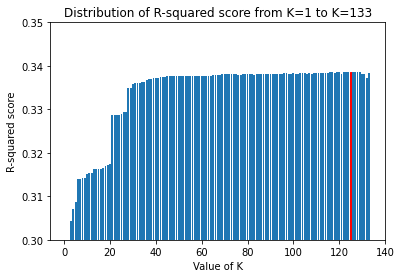

In [ ]:
import matplotlib.pyplot as plt

k_values = list(range(1, 134))
rsquared_values = all_r2

plt.ylim(0.3, 0.35)
bar_r2 = plt.bar(k_values, rsquared_values)
bar_r2[bestr2_index].set_color("red")
plt.xlabel("Value of K")
plt.ylabel("R-squared score")
plt.title("Distribution of R-squared score from K=1 to K=133")
plt.show()

In [ ]:
print("Maximum R-squared score: " + str(round(all_r2[bestr2_index], 3)) + " at K = " + str(bestr2_index+1))
print("R-squared score: " + str(round(all_r2[9], 3)) + " at K = 10")

Maximum R-squared score: 0.339 at K = 125
R-squared score: 0.315 at K = 10
